# ICR - Identifying Age-Related Conditions Dataset with Capsule Neural Networks

This notebook aims to address the task of identifying age-related conditions using Capsule Neural Networks (CapsNet) specifically tuned for binary classification. Age-related conditions pose significant challenges in healthcare, and early detection plays a crucial role in improving patient outcomes and quality of life.

CapsNet is a deep learning architecture known for its ability to capture hierarchical relationships among features, making it suitable for complex pattern recognition tasks. By leveraging the unique properties of CapsNet, we aim to develop a robust model that can accurately classify individuals into two categories: those affected by age-related conditions and those without such conditions.

The dataset used in this notebook consists of diverse features, including demographic information, medical history, and diagnostic tests. Through a series of data preprocessing steps, we will ensure that the data is appropriately prepared for training and evaluation. Additionally, we will employ k-fold cross-validation to assess the model's performance on multiple subsets of the data, enhancing its generalization capabilities.

During model training, we will monitor key metrics such as accuracy and loss to evaluate the model's performance and identify potential overfitting or underfitting issues. Visualizations, including loss curves and accuracy plots, will be utilized to gain insights into the model's learning process and its behavior across different epochs.

Upon selecting the best-performing model based on accuracy and loss, we will further evaluate its performance on a holdout test set to estimate its real-world predictive capabilities. Additionally, we will interpret the model's predictions using techniques like feature importance analysis and explainability tools to gain insights into the factors influencing the classification decisions.

By leveraging CapsNet's unique architecture and employing a rigorous evaluation framework, this notebook aims to contribute to the identification of age-related conditions, enabling early intervention and improved healthcare outcomes. The findings and insights derived from this work can potentially assist healthcare professionals in making informed decisions and provide valuable support in managing age-related conditions.

# Import the libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.12.0


# Load the Dataset

In [3]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
dataset_df = dataset_df.set_index("Id")
# Remove leading or trailing whitespace from column names
dataset_df.columns = dataset_df.columns.str.strip()

print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (617, 57)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [4]:
dataset_df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [5]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


## Pie chart for label column: Class

<Axes: ylabel='Class'>

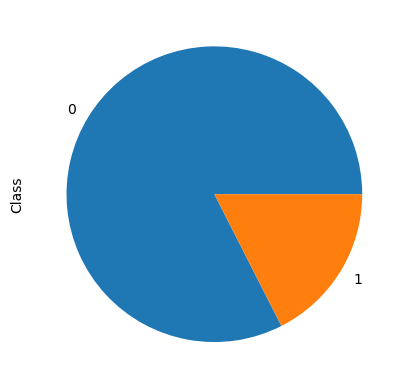

In [6]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

In [7]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

Let us now plot the first 6 numerical columns and their values using bar charts.

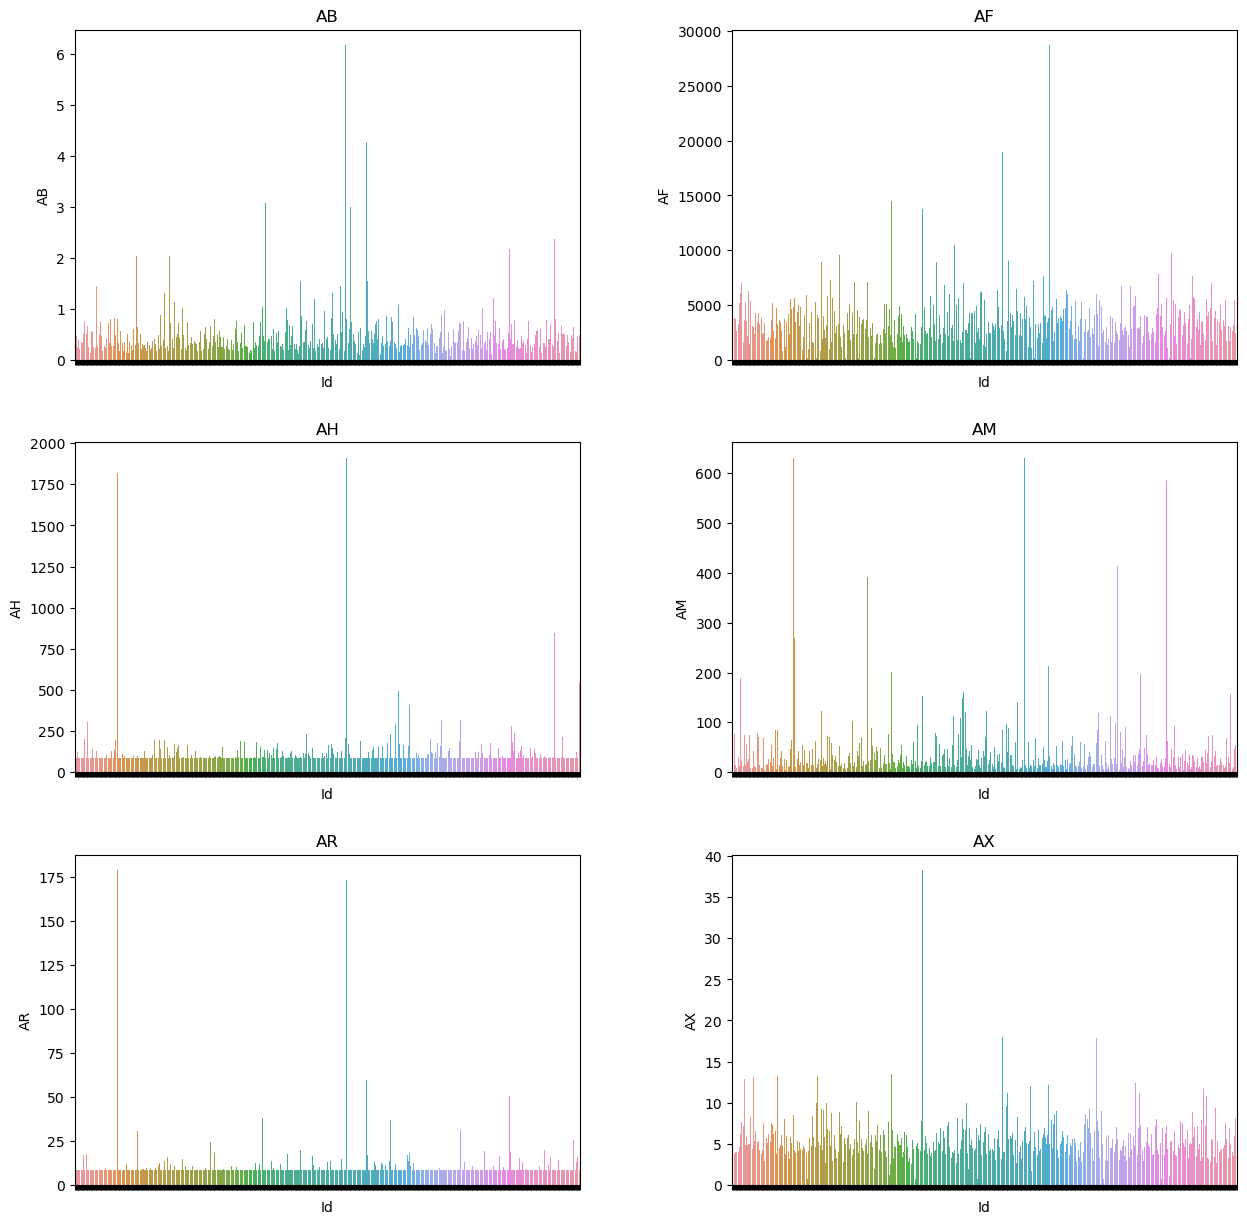

In [8]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df.index, y=dataset_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
plt.show()

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [9]:
FEATURE_COLUMNS = dataset_df.columns

Now let us split the dataset into training and testing datasets:

# KFold validation

We will use Stratified KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

Stratified KFold cross-validation is a powerful technique used in machine learning to evaluate the performance of models, particularly when dealing with imbalanced datasets. It ensures that the distribution of target classes remains consistent across different folds during the validation process.

It is crucial to maintain the proportional representation of our classes in each fold of the cross-validation process. Stratified KFold cross-validation accomplishes this by dividing the dataset into a predetermined number of folds while preserving the relative class distribution in each fold. This technique guarantees that each fold accurately represents the distribution of the target classes found in the overall dataset.

Why is this important? Well, consider a scenario where one age group or condition is significantly underrepresented in the data. If we were to use a regular KFold cross-validation, we might end up with some folds completely lacking instances of that particular age group or condition. This could severely bias our model's performance evaluation, leading to misleading results.

By employing Stratified KFold cross-validation, we can ensure that each fold contains a representative sample of each age group or condition. This approach helps us obtain a more reliable estimation of our model's generalization performance, enabling us to make better-informed decisions about its effectiveness in predicting age-related conditions.

We will split the dataset into 10 consecutive folds. Each fold is then used once as a validation set while the 9 (10-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [10]:
# Creates a GroupKFold with 5 splits
kf = StratifiedKFold(n_splits=10, shuffle=True)

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [11]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
margin_loss_dict = {}

# Save the name of the label column to a variable.
label = "Class"

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [12]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [13]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

# Train Capsule Network Model

A Capsule Network is a type of neural network that consists of groups of neurons called capsules. Each capsule represents a specific feature or entity and can encode its presence and pose (orientation, position, size, etc.) in a vector. The capsules are arranged in layers and communicate with each other through a dynamic routing mechanism that allows them to form part-whole relationships and preserve the spatial hierarchy of the input. A Capsule Network can learn to recognize complex patterns and generalize better than traditional convolutional neural networks, especially for tasks that require viewpoint invariance and pose estimation.

The Capsule Network model will consist of three main layers: an input layer, a primary capsule layer, and a digit capsule layer. The input layer will transform the input vector into a matrix of feature maps using convolutional filters. The primary capsule layer will apply another set of convolutional filters to the feature maps and reshape them into capsules. The digit capsule layer will use a dynamic routing algorithm to compute the activation and pose vectors for each of the four classes (three conditions and one negative class). The activation vector represents the probability that the class is present in the input, while the pose vector represents the parameters of the class. The model will use a margin loss function to optimize the activation vectors and a reconstruction loss function to optimize the pose vectors. The reconstruction loss function will use a decoder network to reconstruct the input vector from the pose vector of the predicted class and compare it with the original input vector.


![Capsule Network diagram](https://www.researchgate.net/publication/369256529/figure/fig1/AS:11431281126975957@1678898063434/Structure-of-the-capsule-network_Q320.jpg)

In this project, I will use a Capsule Network to predict if a person has any of three medical conditions: diabetes, hypertension, or heart disease. The input data consists of measurements of health characteristics such as blood pressure, blood sugar, cholesterol, body mass index, etc. The output is a binary label indicating if the person has one or more of the three conditions (Class 1) or none of them (Class 0). I will train the Capsule Network on a balanced version of the dataset.

By default the model is set to train for a classification task. The margin loss function calculates the loss based on the predicted output y_pred and the true labels y_true. It incorporates margin values for positive and negative examples, as well as a down-weighting parameter for the absent class.

Margin loss is a function that measures the discrepancy between the length of the output vector of a capsule network and a target value. For a binary classification task, the target value is either 0 or 1, depending on the class label. The margin loss can be written as:

$$L = T \cdot \max(0, m^+ - \|v\|)^2 + \lambda (1 - T) \cdot \max(0, \|v\| - m^-)^2$$

where $T$ is the target value, $v$ is the output vector of the capsule network, $m^+$ and $m^-$ are the margins for the positive and negative classes, respectively, and $\lambda$ is a regularization parameter that balances the loss between the two classes.

After defining the margin loss function, we compile the model using model.compile() and set the loss to be the margin loss function.

Now, when you call CapsuleNetwork(), it will return a model with the margin loss function as the optimization objective.

In [14]:
## Taken from https://github.com/keras-team/keras-contrib/tree/master/keras_contrib

# -*- coding: utf-8 -*-
from __future__ import absolute_import

from keras import backend as K
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.layers import Layer

def to_tuple(shape):
    """This functions is here to fix an inconsistency between keras and tf.keras.

    In tf.keras, the input_shape argument is an tuple with `Dimensions` objects.
    In keras, the input_shape is a simple tuple of ints or `None`.

    We'll work with tuples of ints or `None` to be consistent
    with keras-team/keras. So we must apply this function to
    all input_shapes of the build methods in custom layers.
    """
    return tuple(tf.TensorShape(shape).as_list())

class Capsule(Layer):
    """Capsule Layer implementation in Keras

       This implementation is based on Dynamic Routing of Capsules,
       Geoffrey Hinton et. al.

       The Capsule Layer is a Neural Network Layer which helps
       modeling relationships in image and sequential data better
       than just CNNs or RNNs. It achieves this by understanding
       the spatial relationships between objects (in images)
       or words (in text) by encoding additional information
       about the image or text, such as angle of rotation,
       thickness and brightness, relative proportions etc.
       This layer can be used instead of pooling layers to
       lower dimensions and still capture important information
       about the relationships and structures within the data.
       A normal pooling layer would lose a lot of
       this information.

       This layer can be used on the output of any layer
       which has a 3-D output (including batch_size). For example,
       in image classification, it can be used on the output of a
       Conv2D layer for Computer Vision applications. Also,
       it can be used on the output of a GRU or LSTM Layer
       (Bidirectional or Unidirectional) for NLP applications.

       The default activation function is 'linear'. But, this layer
       is generally used with the 'squash' activation function
       (recommended). To use the squash activation function, do :

       from keras_contrib.activations import squash

       capsule = Capsule(num_capsule=10,
                         dim_capsule=10,
                         routings=3,
                         share_weights=True,
                         activation=squash)

       # Example usage :
           1). COMPUTER VISION

           input_image = Input(shape=(None, None, 3))

           conv_2d = Conv2D(64,
                            (3, 3),
                            activation='relu')(input_image)

           capsule = Capsule(num_capsule=10,
                             dim_capsule=16,
                             routings=3,
                             activation='relu',
                             share_weights=True)(conv_2d)

           2). NLP

           maxlen = 72
           max_features = 120000
           input_text = Input(shape=(maxlen,))

           embedding = Embedding(max_features,
                                 embed_size,
                                 weights=[embedding_matrix],
                                 trainable=False)(input_text)

           bi_gru = Bidirectional(GRU(64,
                                      return_seqeunces=True))(embedding)

           capsule = Capsule(num_capsule=5,
                             dim_capsule=5,
                             routings=4,
                             activation='sigmoid',
                             share_weights=True)(bi_gru)

       # Arguments
           num_capsule : Number of Capsules (int)
           dim_capsules : Dimensions of the vector output of each Capsule (int)
           routings : Number of dynamic routings in the Capsule Layer (int)
           share_weights : Whether to share weights between Capsules or not
           (boolean)
           activation : Activation function for the Capsules
           regularizer : Regularizer for the weights of the Capsules
           initializer : Initializer for the weights of the Caspules
           constraint : Constraint for the weights of the Capsules

       # Input shape
            3D tensor with shape:
            (batch_size, input_num_capsule, input_dim_capsule)
            [any 3-D Tensor with the first dimension as batch_size]

       # Output shape
            3D tensor with shape:
            (batch_size, num_capsule, dim_capsule)

       # References
        - [Dynamic-Routing-Between-Capsules]
          (https://arxiv.org/pdf/1710.09829.pdf)
        - [Keras-Examples-CIFAR10-CNN-Capsule]"""

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_shape = to_tuple(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        # u_hat_vectors : The spatially transformed input vectors (with local_conv_1d)

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = {'num_capsule': self.num_capsule,
                  'dim_capsule': self.dim_capsule,
                  'routings': self.routings,
                  'share_weights': self.share_weights,
                  'activation': activations.serialize(self.activation),
                  'regularizer': regularizers.serialize(self.regularizer),
                  'initializer': initializers.serialize(self.initializer),
                  'constraint': constraints.serialize(self.constraint)}

        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Margin Loss function
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    m_plus = 0.9  # Margin for positive examples
    m_minus = 0.1  # Margin for negative examples
    lambda_ = 0.5  # Down-weighting parameter for the absent class
    # Cast y_true to float32
    y_true = K.cast(y_true, dtype='float32')
    
    L = y_true * K.square(K.maximum(0.0, m_plus - y_pred)) + \
        lambda_ * (1. - y_true) * K.square(K.maximum(0.0, y_pred - m_minus))

    return K.mean(K.sum(L, axis=1))

# Define the Capsule Network model
def CapsuleNetwork(in_features=55):
    input_shape = (in_features,)  # Update with the number of features in your dataset

    # Encoder
    inputs = keras.Input(shape=input_shape)
    x = layers.Reshape(target_shape=(in_features, 1))(inputs)
    x = layers.Conv1D(filters=128, kernel_size=9, activation='relu')(x)
    x = layers.Conv1D(filters=128, kernel_size=9, activation='relu', strides=2)(x)
    x = layers.Conv1D(filters=256, kernel_size=9, activation='relu')(x)
    x = layers.Conv1D(filters=256, kernel_size=9, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Reshape(target_shape=(-1, 256))(x)
    primary_caps = Capsule(num_capsule=8, dim_capsule=16, routings=3)(x)

    # DigitCaps layer
    digit_caps = Capsule(num_capsule=1, dim_capsule=16, routings=3)(primary_caps)

    # Decoder
    x = layers.Flatten()(digit_caps)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

The margin loss function in a capsule network combines concepts from calculus and linear algebra to optimize the network's performance and enhance its discriminative capabilities. Let's dive into the key mathematical concepts involved:

1. **Vector Operations:** In linear algebra, vectors are fundamental entities that represent quantities with both magnitude and direction. In the context of a capsule network, the feature vectors can be thought of as high-dimensional vectors that encode information about the input data. These vectors can be manipulated using various vector operations, such as addition, subtraction, and dot products.

2. **Sigmoid Activation:** The margin loss function operates on the outputs of the network, which are usually passed through a sigmoid activation function. The sigmoid function maps the inputs (e.g., the output logits) to a range between 0 and 1, providing a smooth and differentiable activation. This activation is crucial for applying gradient-based optimization methods, such as backpropagation, to update the network parameters.

3. **Squares and Maximum Operations:** Within the margin loss function, we encounter the square and maximum operations. Squaring a value is a common operation used in optimization objectives, such as mean squared error. It ensures that all terms contribute positively to the loss, penalizing larger errors more heavily. The maximum operation, denoted as K.maximum(a, b), returns the element-wise maximum between two vectors a and b. It selects the larger value at each element position, allowing us to introduce margins into the loss calculation. For example, in the margin loss, we use K.maximum(0.0, m_plus - y_pred) to ensure that the difference between m_plus (the positive margin) and y_pred (the predicted activation) is non-negative.

4. **Weighting Positive and Negative Examples:** The margin loss function accounts for the presence of positive and negative examples using class weights. These class weights are incorporated in the loss function to handle imbalanced datasets, assigning different weights to each class. The weights influence the magnitude of the loss for each example during training, allowing the network to focus more on challenging or underrepresented classes.

By leveraging these mathematical concepts, the margin loss function operates on large feature vectors to optimize the capsule network's parameters. The loss is computed by comparing the true labels (y_true) with the predicted activations (y_pred) and applying the margin constraints. The squared differences between the margins and the activations are computed using vector operations, and the final loss is determined by summing and averaging these squared differences.

The power of the margin loss function lies in its ability to optimize the network's parameters based on the margin distances between the predicted activations and the desired margins. This encourages the network to learn distinct and separable representations, enhancing its discriminative capabilities.

In summary, the margin loss function leverages concepts from calculus and linear algebra to optimize the performance of a capsule network. Through various mathematical operations on large feature vectors, it encourages the network to learn meaningful representations and adapt to imbalanced datasets.

In [16]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels_in_df = False
    if 'Class' in dataframe.columns:
        labels_in_df = True
        labels = dataframe.pop('Class')
    float_columns = dataframe.select_dtypes(include=['float']).columns
    dataframe[float_columns] = dataframe[float_columns].astype('float32')
        
    # Convert non-numeric values to NaN
    dataframe[float_columns] = dataframe[float_columns].apply(pd.to_numeric, errors='coerce')

    # Normalize the numerical columns
    #scaler = StandardScaler()
    #dataframe[float_columns] = scaler.fit_transform(dataframe[float_columns])
        
    # Replace missing values with 0
    dataframe[float_columns] = dataframe[float_columns].fillna(0)

    if labels_in_df:
        ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(dataframe[float_columns].values, dtype=tf.float32), tf.convert_to_tensor(labels.values, dtype=tf.float32)))
    else:
        ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(dataframe[float_columns].values, dtype=tf.float32))
        
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

df_to_dataset(dataset_df)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Harnessing the Power of Multiple Neural Networks

In the realm of machine learning, we explore a technique that combines the strengths of multiple neural networks to enhance prediction capability. This approach offers a range of benefits and considerations that shape our quest for improved accuracy and performance.

### The Ensemble Approach

Our methodology revolves around an ensemble of neural networks, each specialized in analyzing a specific set of features derived from our data. By segmenting the data into different feature vectors, we capture diverse patterns and intricacies that may elude a single model. This ensemble of networks functions as a collective, bringing forth a comprehensive understanding of the data landscape.

### Unifying Predictions

At the core of our approach lies a meta model, which acts as a unifying entity to leverage the insights from individual networks. It integrates their predictions, creating a unified prediction that amalgamates the diverse perspectives of the constituent models. This meta model uncovers complex relationships and synergies among the features, leading to enhanced prediction capability.

### Benefits and Considerations

While this approach shows great promise, it also comes with certain considerations. Coordinating multiple neural networks and the meta model demands computational resources and careful calibration. Training and fine-tuning these models require attention to detail and optimization techniques to achieve optimal performance.

Interpreting the individual neural networks' predictions may require diligent analysis and exploration. Extracting meaningful insights from their combined outputs can provide a deeper understanding of the data and improve decision-making processes.

### Amplifying Prediction Capability

Through the combined efforts of multiple neural networks and the meta model, our approach offers improved prediction capability for new data. The ensemble harnesses the collective intelligence and adaptability of the models, making predictions more robust and resilient to various data scenarios. By leveraging the diverse perspectives of the individual networks, we achieve a comprehensive understanding that transcends the limitations of a single model.

In our pursuit of accuracy and performance, this methodology empowers us to harness the power of multiple neural networks. With careful calibration, analysis, and interpretation, we unlock the potential for superior predictions, advancing our understanding and decision-making in the domain of machine learning.


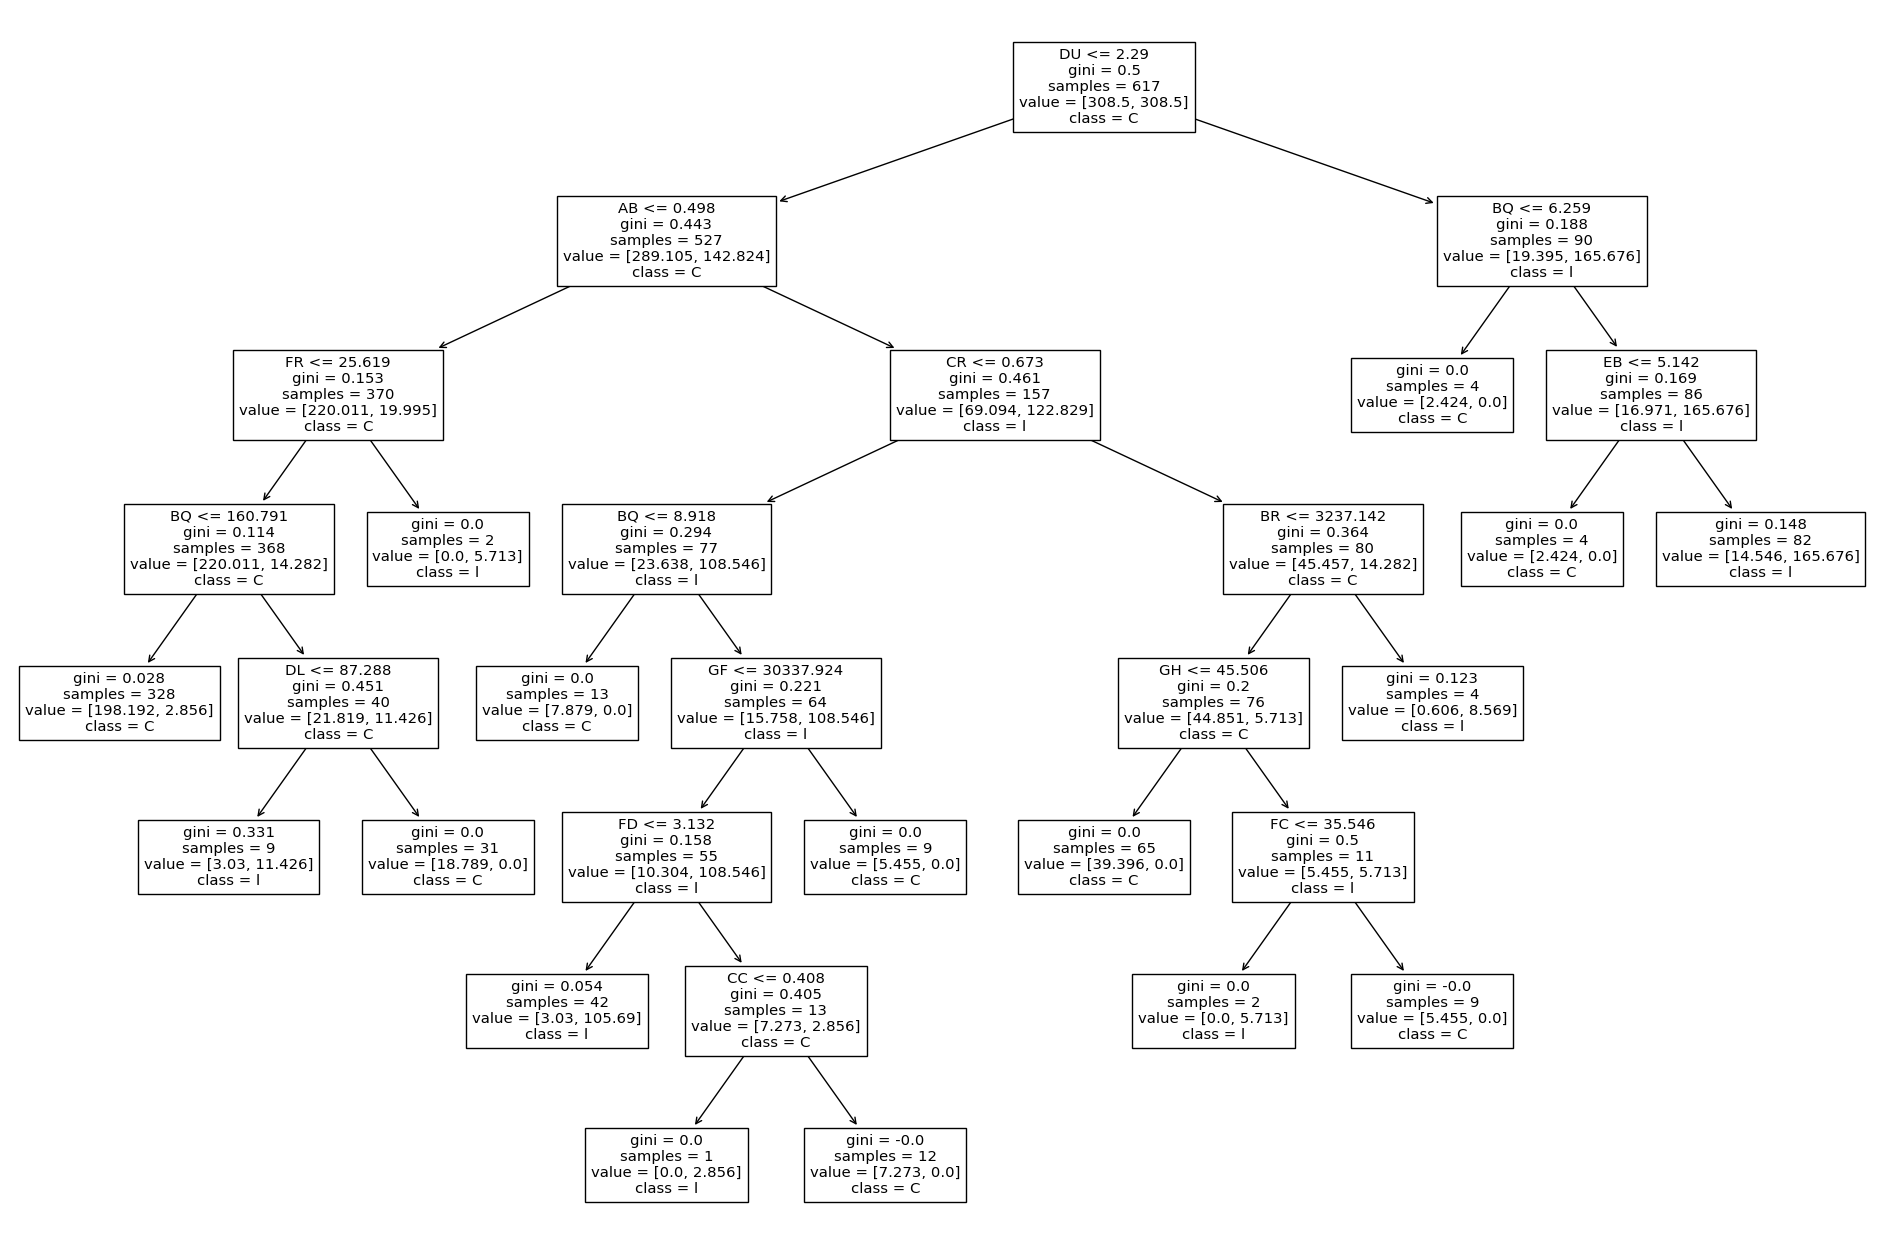

In [17]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from pandas.api.types import is_numeric_dtype
from sklearn.tree import export_graphviz 
import cv2
  
def convert_cats(df):
        cats = []
        for col in df.columns:
            if is_numeric_dtype(df[col]):
                pass
            else:
                cats.append(col)
        for col in cats:
            df[col] = df[col].astype('category')
            
        return df

full_df = dataset_df.copy()

float_columns = full_df.select_dtypes(include=['float']).columns
full_df[float_columns] = full_df[float_columns].astype('float32')
full_df = convert_cats(full_df)
# Convert non-numeric values to NaN
full_df[float_columns] = full_df[float_columns].apply(pd.to_numeric, errors='coerce')

# Replace missing values with 0
full_df[float_columns] = full_df[float_columns].fillna(0)

# Fit the regressor, set max_depth = 3
decision_tree = DecisionTreeClassifier(max_leaf_nodes=16, class_weight=class_weight, random_state=int(time.time()))
decision_tree = decision_tree.fit(full_df[float_columns], full_df['Class'])

plt.figure(figsize=(24,16))
tree.plot_tree(decision_tree, feature_names=float_columns, class_names='Class')
plt.show()

In [18]:
# Get the decision paths
decision_paths = decision_tree.decision_path(full_df[float_columns]).toarray()

# Get the column names
column_names = decision_tree.feature_names_in_

# Create a list of feature lists for each path
feature_lists = []
for path in decision_paths:
    feature_list = []
    for node, value in enumerate(path):
        if value == 1:
            feature_list.append(column_names[decision_tree.tree_.feature[node]])
    feature_lists.append(feature_list)
    
top_feature_lists = list(set(tuple(feature_list) for feature_list in feature_lists))
top_feature_lists += [set(float_columns)-set([item for sublist in top_feature_lists for item in sublist])]
top_feature_lists = [sorted(list(f)) for f in top_feature_lists]
top_feature_lists

[['AB', 'BR', 'CR', 'DU', 'FC', 'GH', 'GI'],
 ['AB', 'BR', 'CR', 'DU', 'GI'],
 ['AB', 'BQ', 'CR', 'DU', 'GI'],
 ['AB', 'BQ', 'DL', 'DU', 'FR', 'GI'],
 ['AB', 'BQ', 'CR', 'DU', 'GF', 'GI'],
 ['BQ', 'DU', 'GI'],
 ['AB', 'BQ', 'CR', 'DU', 'FD', 'GF', 'GI'],
 ['AB', 'DU', 'FR', 'GI'],
 ['AB', 'BQ', 'CC', 'CR', 'DU', 'FD', 'GF', 'GI'],
 ['AB', 'BR', 'CR', 'DU', 'GH', 'GI'],
 ['AB', 'BQ', 'DU', 'FR', 'GI'],
 ['BQ', 'DU', 'EB', 'GI'],
 ['AF',
  'AH',
  'AM',
  'AR',
  'AX',
  'AY',
  'AZ',
  'BC',
  'BD',
  'BN',
  'BP',
  'BZ',
  'CB',
  'CD',
  'CF',
  'CH',
  'CL',
  'CS',
  'CU',
  'CW',
  'DA',
  'DE',
  'DF',
  'DH',
  'DI',
  'DN',
  'DV',
  'DY',
  'EE',
  'EG',
  'EH',
  'EL',
  'EP',
  'EU',
  'FE',
  'FI',
  'FL',
  'FS',
  'GB',
  'GE',
  'GL']]

In [19]:
def create_model(corresponding_df):
    feat_list = corresponding_df.columns
    # Define the feature columns list
    feature_columns = []

    # Iterate over the columns in the dataset
    for column in feat_list:
        if column != 'Class':  # Exclude the target column if present
            if dataset_df[column].dtype == 'object':
                # Categorical column
                vocab = dataset_df[column].unique()
                cat_column = tf.feature_column.categorical_column_with_vocabulary_list(column, vocab)
                feature_columns.append(tf.feature_column.indicator_column(cat_column))
            else:
                # Numeric column
                feature_columns.append(tf.feature_column.numeric_column(column))
    
    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=(len(feature_columns),))
    
    # Reshape the input layer to match the expected input shape for the CNN
    reshaped_input = tf.keras.layers.Reshape((-1, 1))(input_layer)

    # Convolutional layers
    conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(reshaped_input)
    conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv1)
    conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv2)

    # Flatten the convolutional outputs
    flattened = tf.keras.layers.Flatten()(conv3)
  
    # Define the hidden layers
    x = layers.Dense(128, activation='relu')(flattened)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)

    # Define the output layer
    outputs = layers.Dense(1)(x)
    
    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=outputs)
    
    return model

models = [create_model(dataset_df[list(flist)]) for flist in top_feature_lists]

# Combine the outputs of individual models
outputs = [model.output for model in models]  # Access the second-to-last layer

# Define the meta_model architecture
meta_model_input = layers.concatenate(outputs)
meta_model_hidden = layers.Dense(36, activation='relu')(meta_model_input)
meta_model_output = layers.Dense(1, activation='sigmoid')(meta_model_hidden)

# Create the meta_model
meta_model = tf.keras.models.Model(inputs=[model.input for model in models], outputs=meta_model_output)

# Compile the meta_model
meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

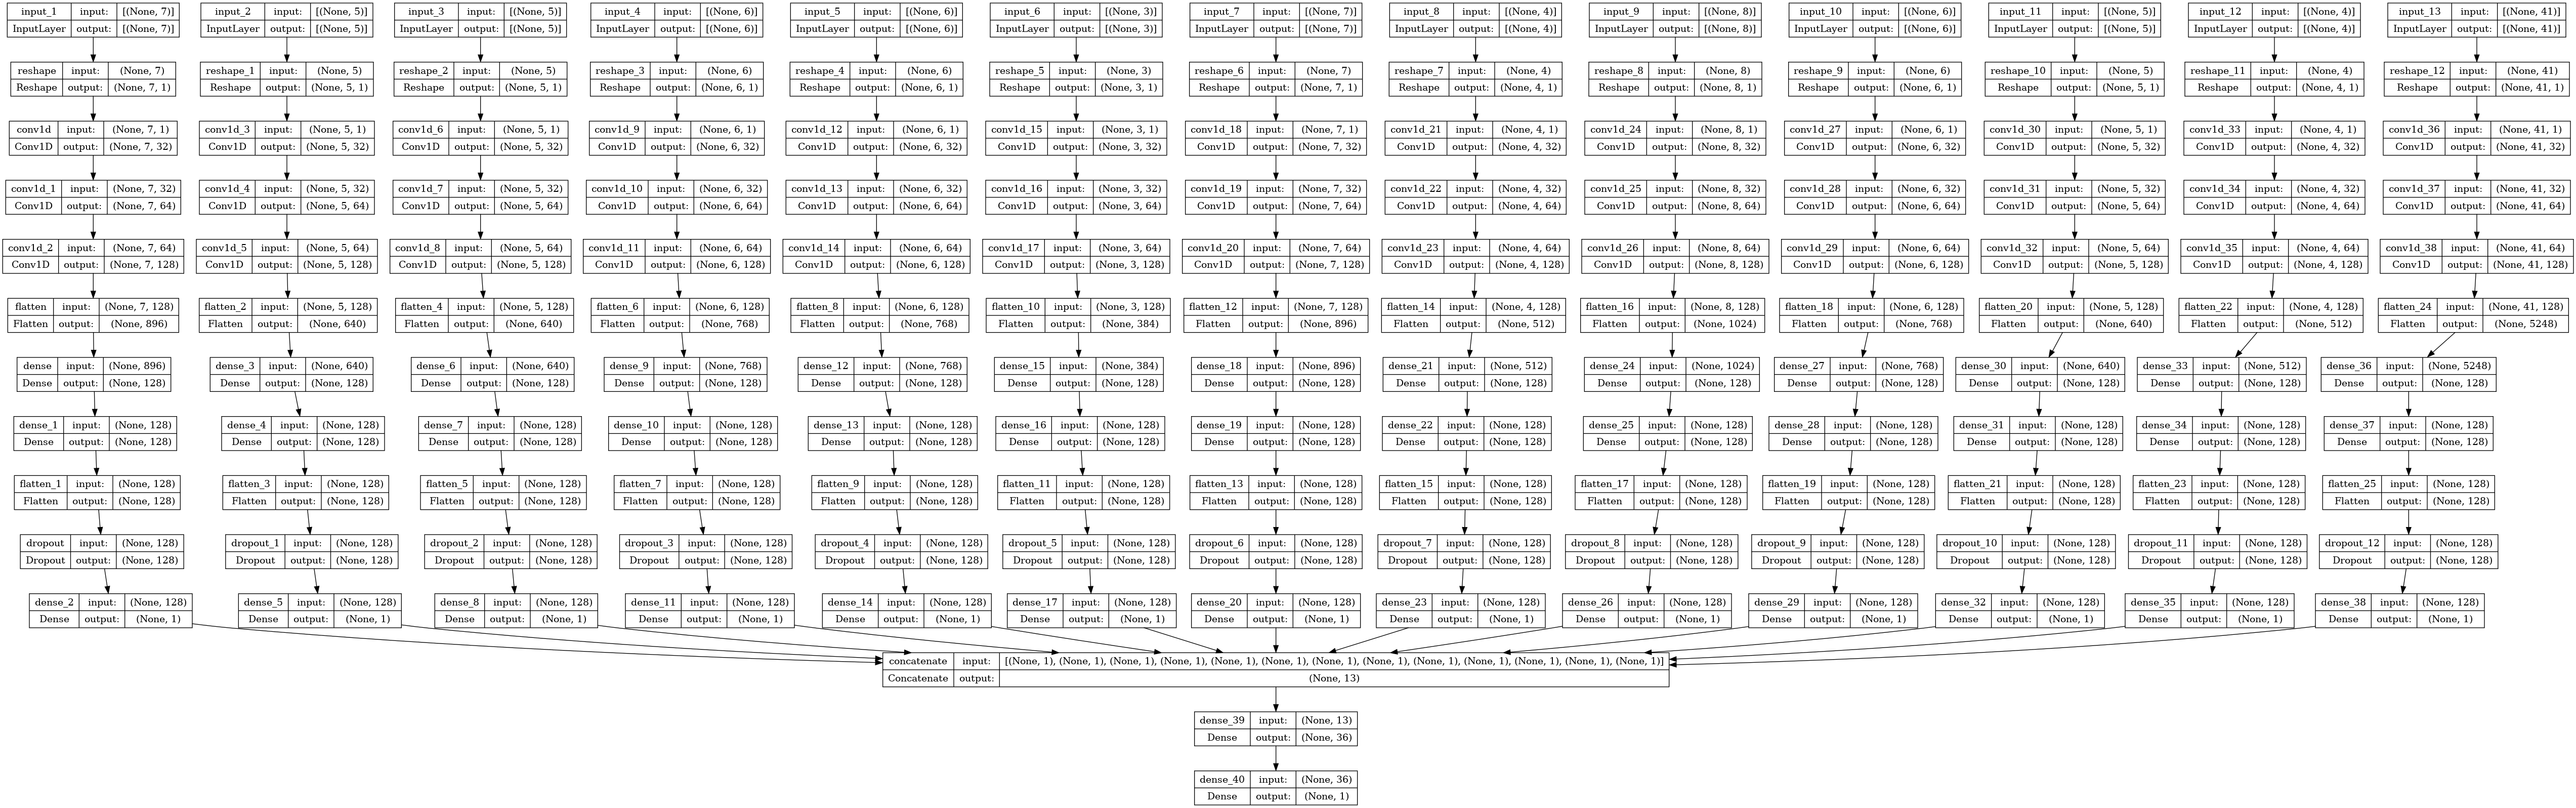

In [20]:
from tensorflow.keras.utils import plot_model

# Assuming you have already created the meta_model
# ...

# Visualize the meta_model
plot_model(meta_model, to_file='meta_model.png', show_shapes=True)

##### Fold 1
Epoch 1/50
18/18 [==============================] - 2s 23ms/step - loss: 12.3167 - accuracy: 0.3676 - val_loss: 4.0329 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 0s 9ms/step - loss: 3.5927 - accuracy: 0.5514 - val_loss: 0.5814 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 0s 9ms/step - loss: 3.5650 - accuracy: 0.5045 - val_loss: 1.8833 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 4.1553 - accuracy: 0.4559 - val_loss: 6.3561 - val_accuracy: 0.2742 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 8.8164 - accuracy: 0.4486 - val_loss: 8.2926 - val_accuracy: 0.2742 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 6.6176 - accuracy: 0.3784 - val_loss: 5.3026 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 7/50
10/18 [===============>..............] - ETA: 0s - loss:

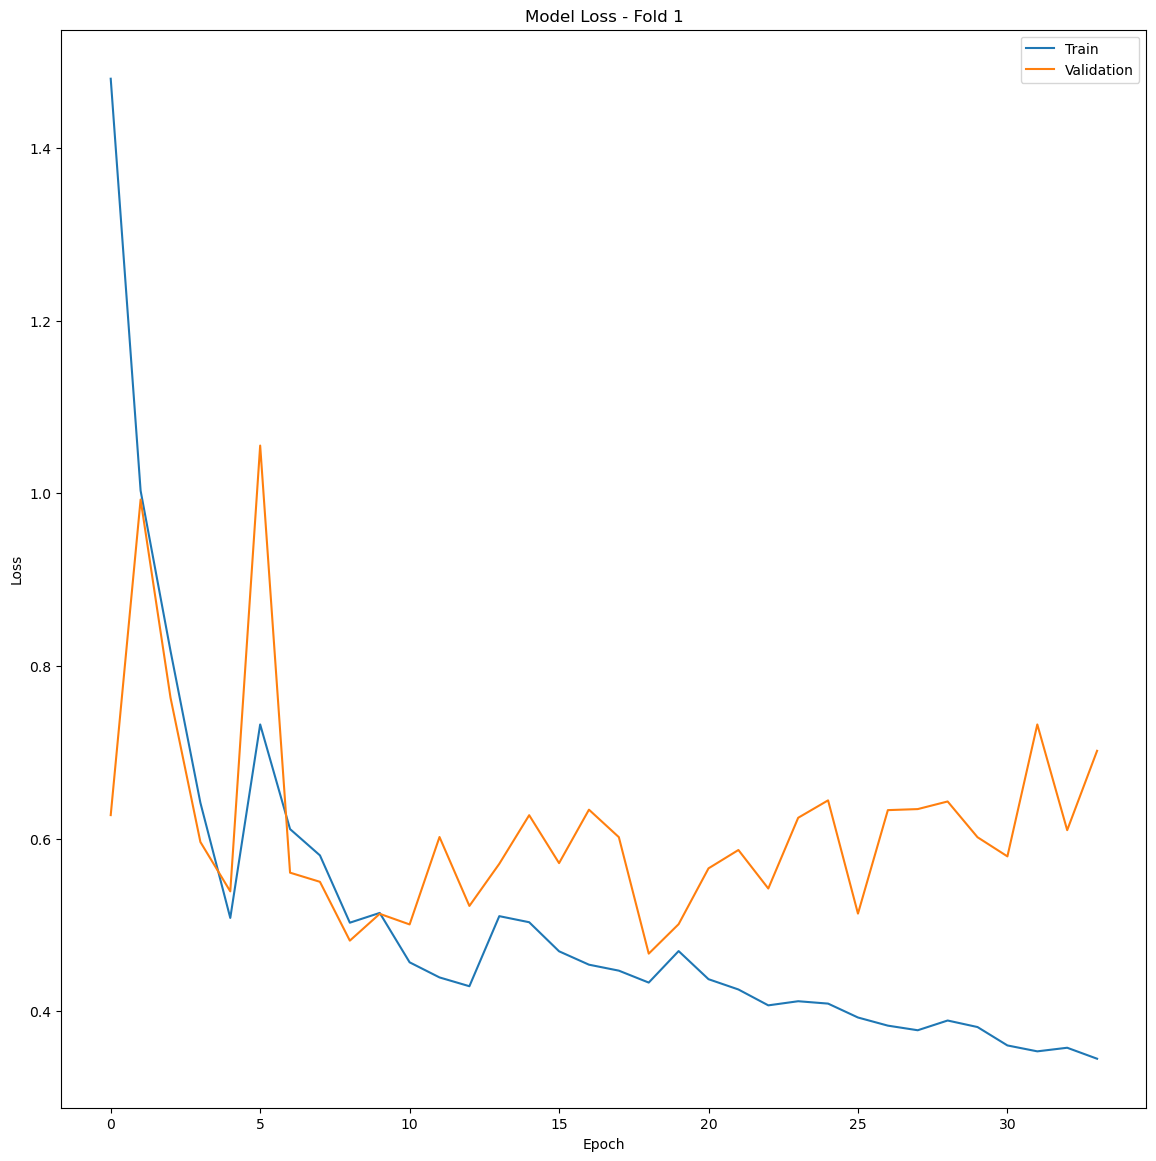

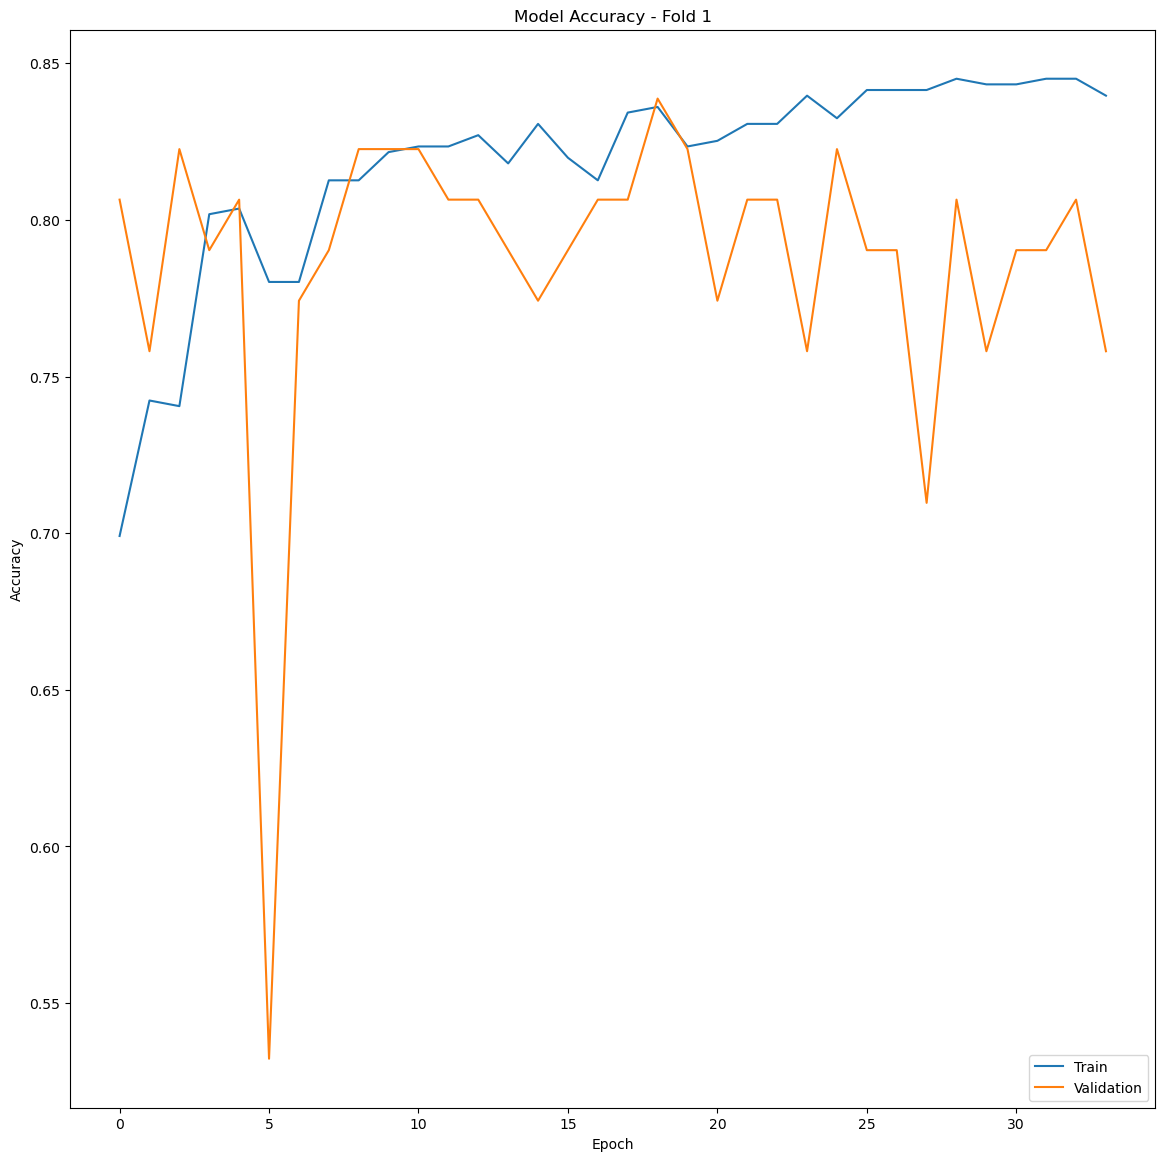

2/2 [==============================] - 0s 13ms/step - loss: 0.5560 - accuracy: 0.7903
##### Fold 2
Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 2.6521 - accuracy: 0.7027 - val_loss: 1.3096 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 1.0534 - accuracy: 0.4955 - val_loss: 1.0132 - val_accuracy: 0.5968 - lr: 5.0000e-04
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9135 - accuracy: 0.6829 - val_loss: 1.2738 - val_accuracy: 0.5161 - lr: 5.0000e-04
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 1.0861 - accuracy: 0.5027 - val_loss: 1.1761 - val_accuracy: 0.5968 - lr: 5.0000e-04
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.8712 - accuracy: 0.6919 - val_loss: 0.7842 - val_accuracy: 0.7258 - lr: 5.0000e-04
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 1.4112 - accuracy: 0.7568 - val_loss: 0.9308

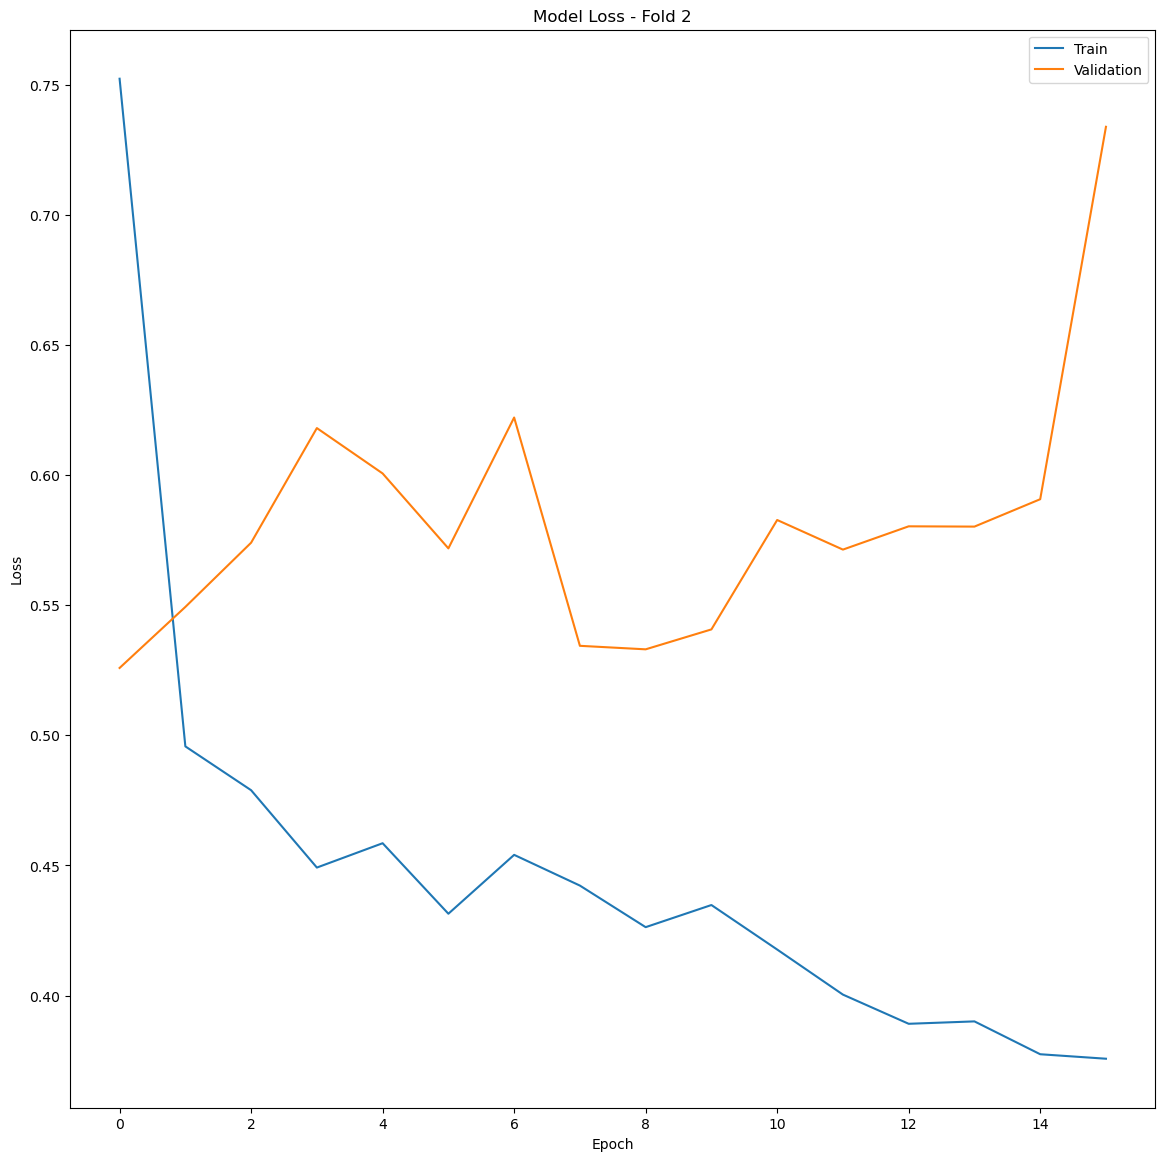

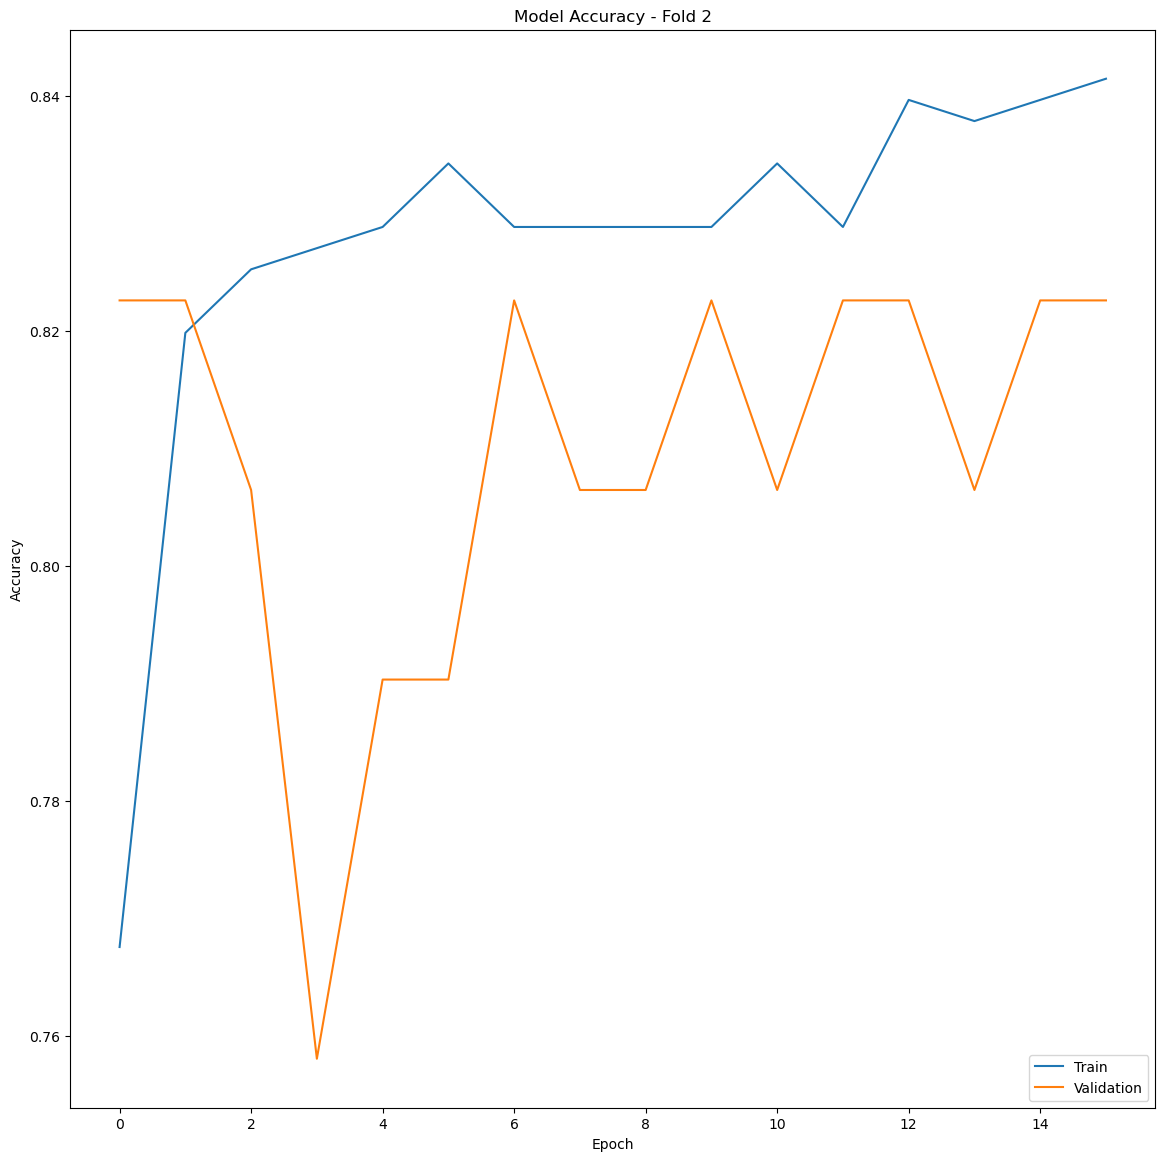

2/2 [==============================] - 0s 14ms/step - loss: 0.6081 - accuracy: 0.8226
##### Fold 3
Epoch 1/50
18/18 [==============================] - 0s 9ms/step - loss: 2.9225 - accuracy: 0.7748 - val_loss: 0.7901 - val_accuracy: 0.7097 - lr: 2.5000e-04
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.8171 - accuracy: 0.6775 - val_loss: 0.7438 - val_accuracy: 0.7258 - lr: 2.5000e-04
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7448 - accuracy: 0.7730 - val_loss: 0.6680 - val_accuracy: 0.7097 - lr: 2.5000e-04
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6871 - accuracy: 0.7874 - val_loss: 0.6402 - val_accuracy: 0.7581 - lr: 2.5000e-04
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7318 - accuracy: 0.7946 - val_loss: 0.6382 - val_accuracy: 0.7903 - lr: 2.5000e-04
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6771 - accuracy: 0.7928 - val_loss: 0.6638

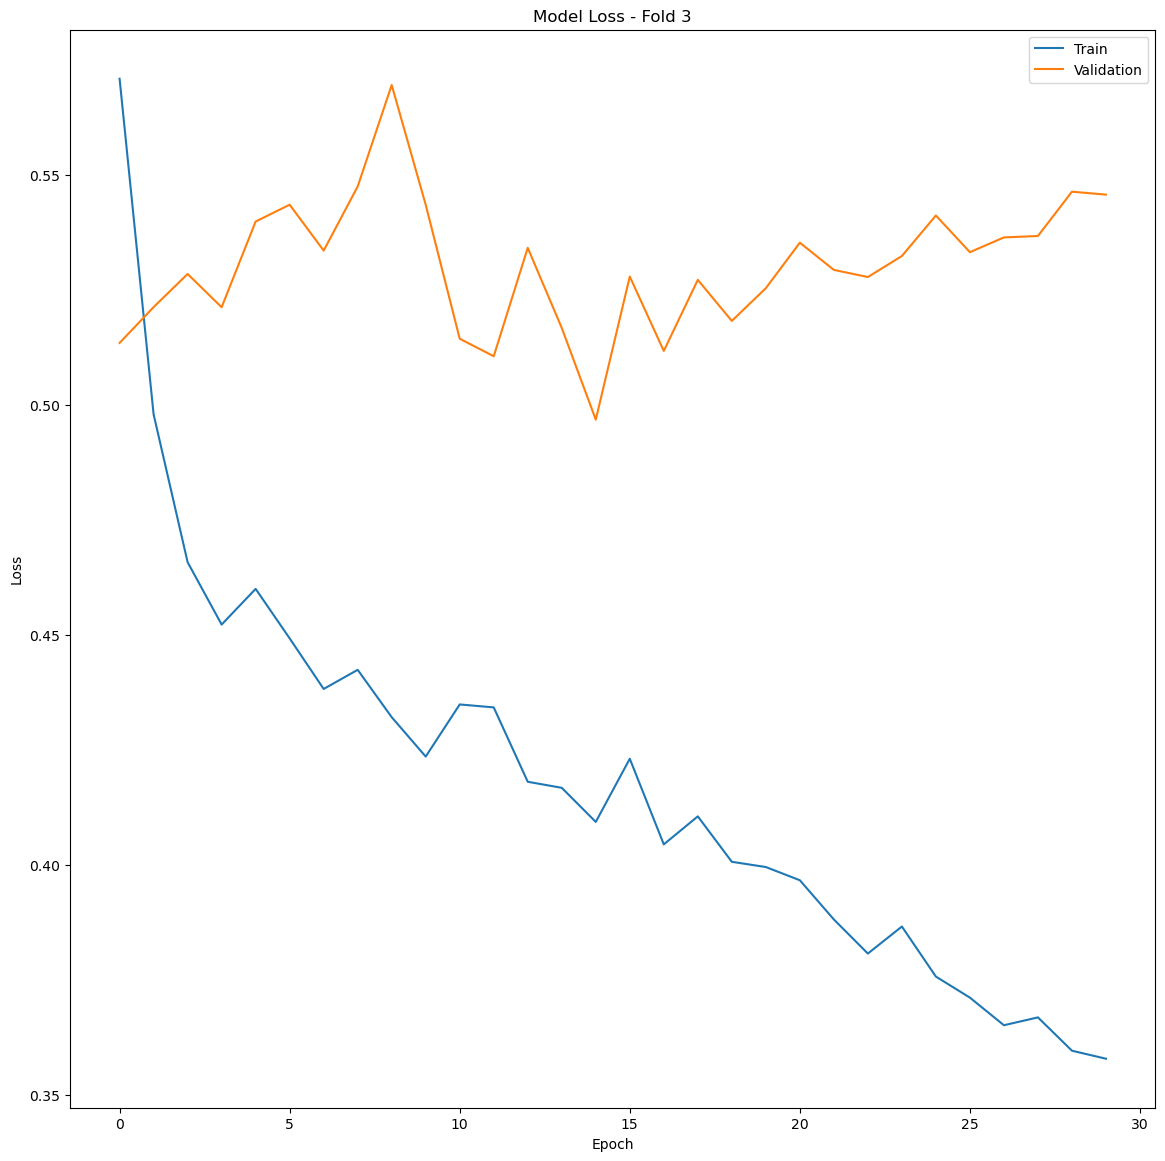

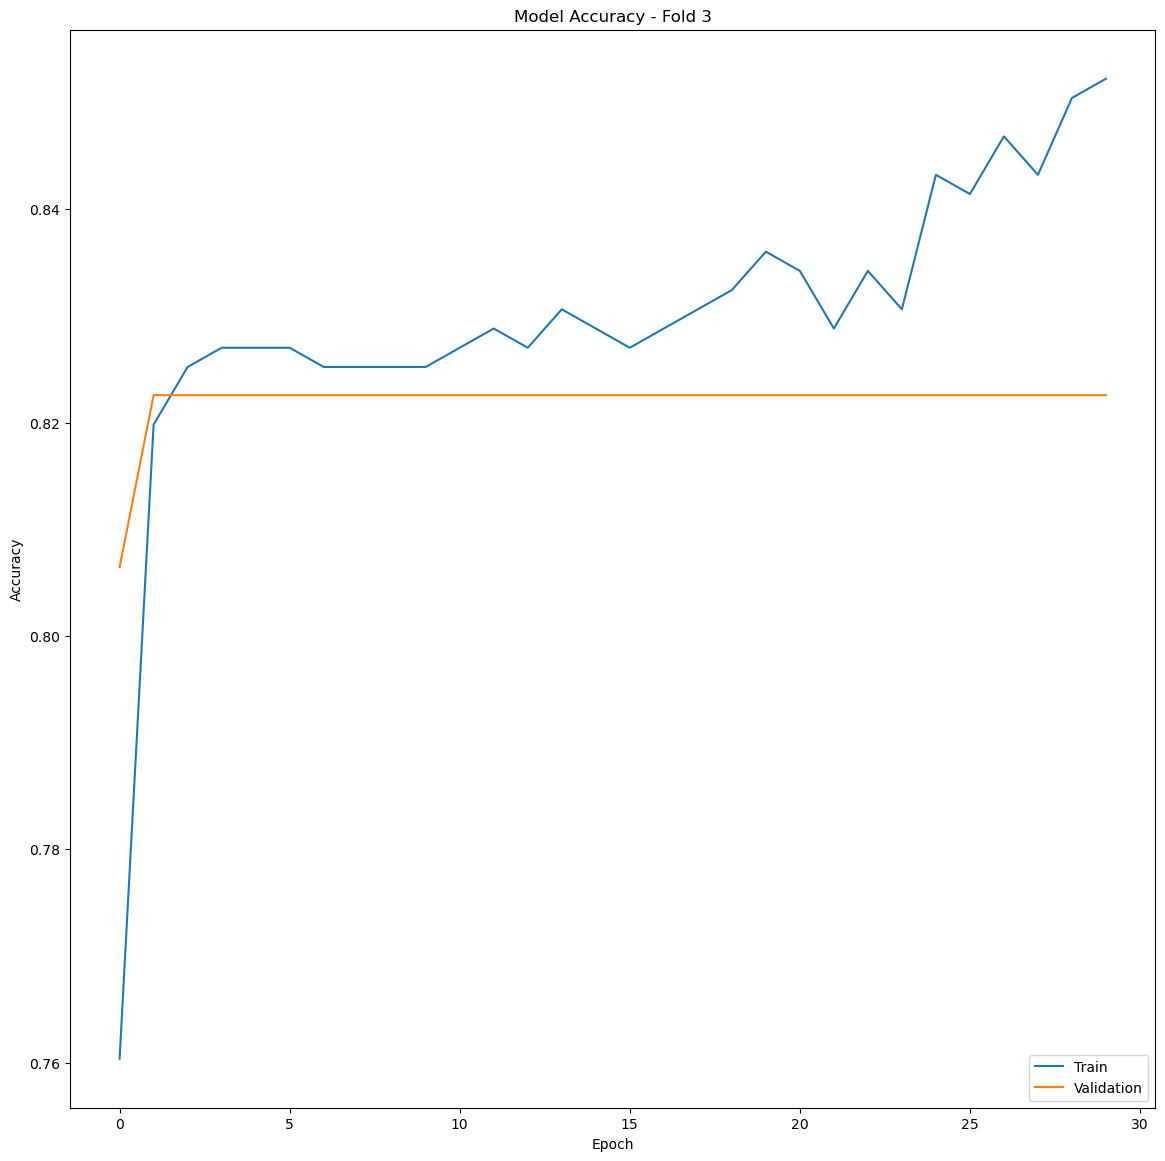

2/2 [==============================] - 0s 19ms/step - loss: 0.5277 - accuracy: 0.8226
##### Fold 4
Epoch 1/50
18/18 [==============================] - 0s 8ms/step - loss: 0.8645 - accuracy: 0.8198 - val_loss: 0.5226 - val_accuracy: 0.8065 - lr: 1.2500e-04
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7954 - accuracy: 0.8018 - val_loss: 0.5524 - val_accuracy: 0.8226 - lr: 1.2500e-04
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7668 - accuracy: 0.7694 - val_loss: 0.5900 - val_accuracy: 0.8226 - lr: 1.2500e-04
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7236 - accuracy: 0.7550 - val_loss: 0.6017 - val_accuracy: 0.8226 - lr: 1.2500e-04
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7067 - accuracy: 0.7712 - val_loss: 0.6034 - val_accuracy: 0.8226 - lr: 1.2500e-04
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.7676
Epoch 6: ReduceLROnPla

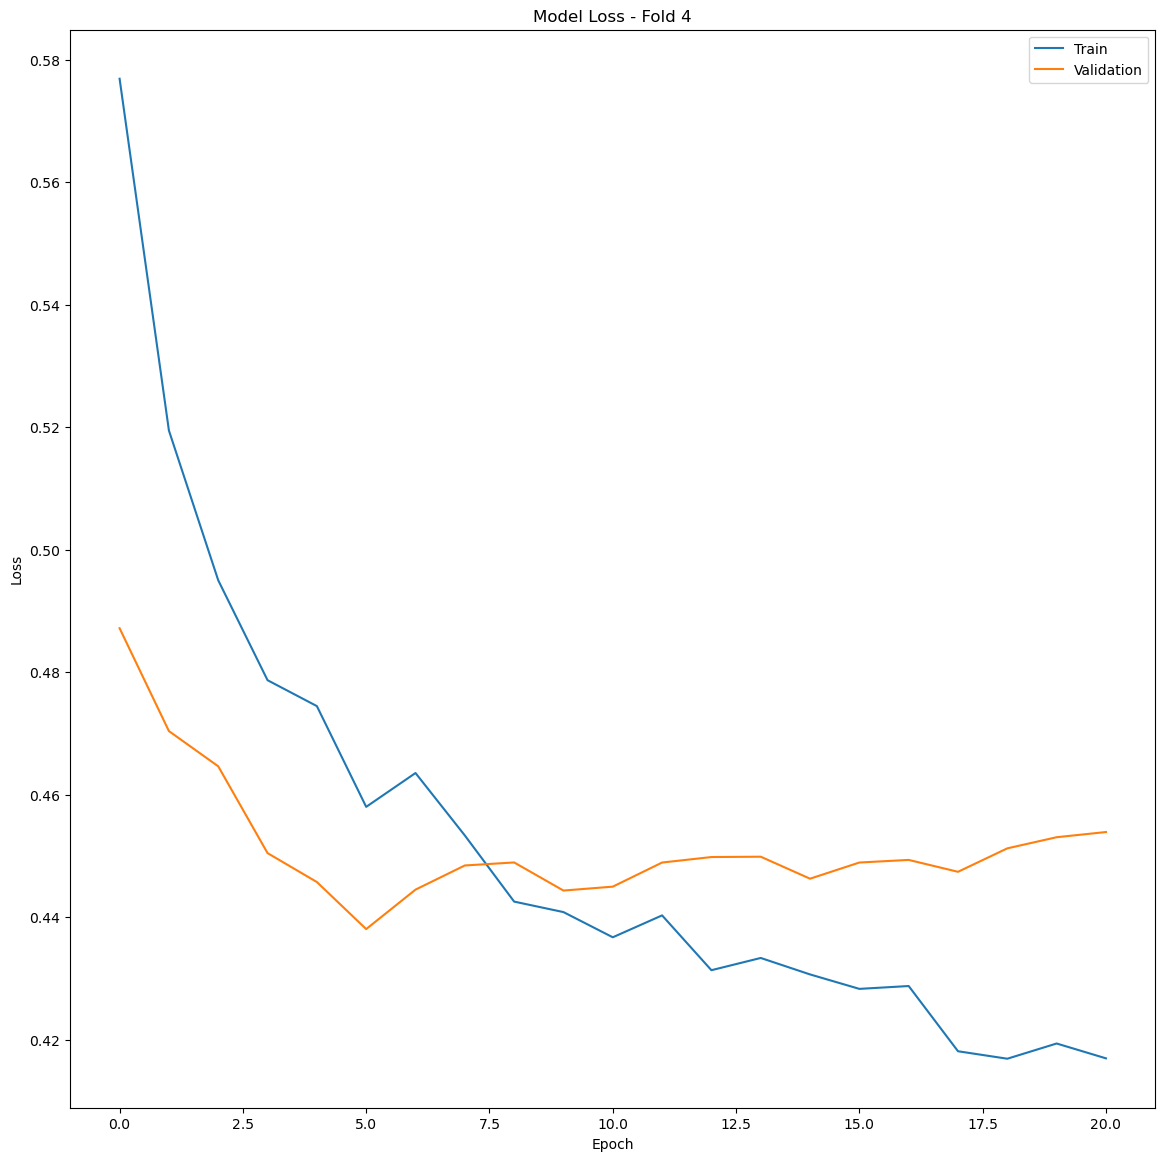

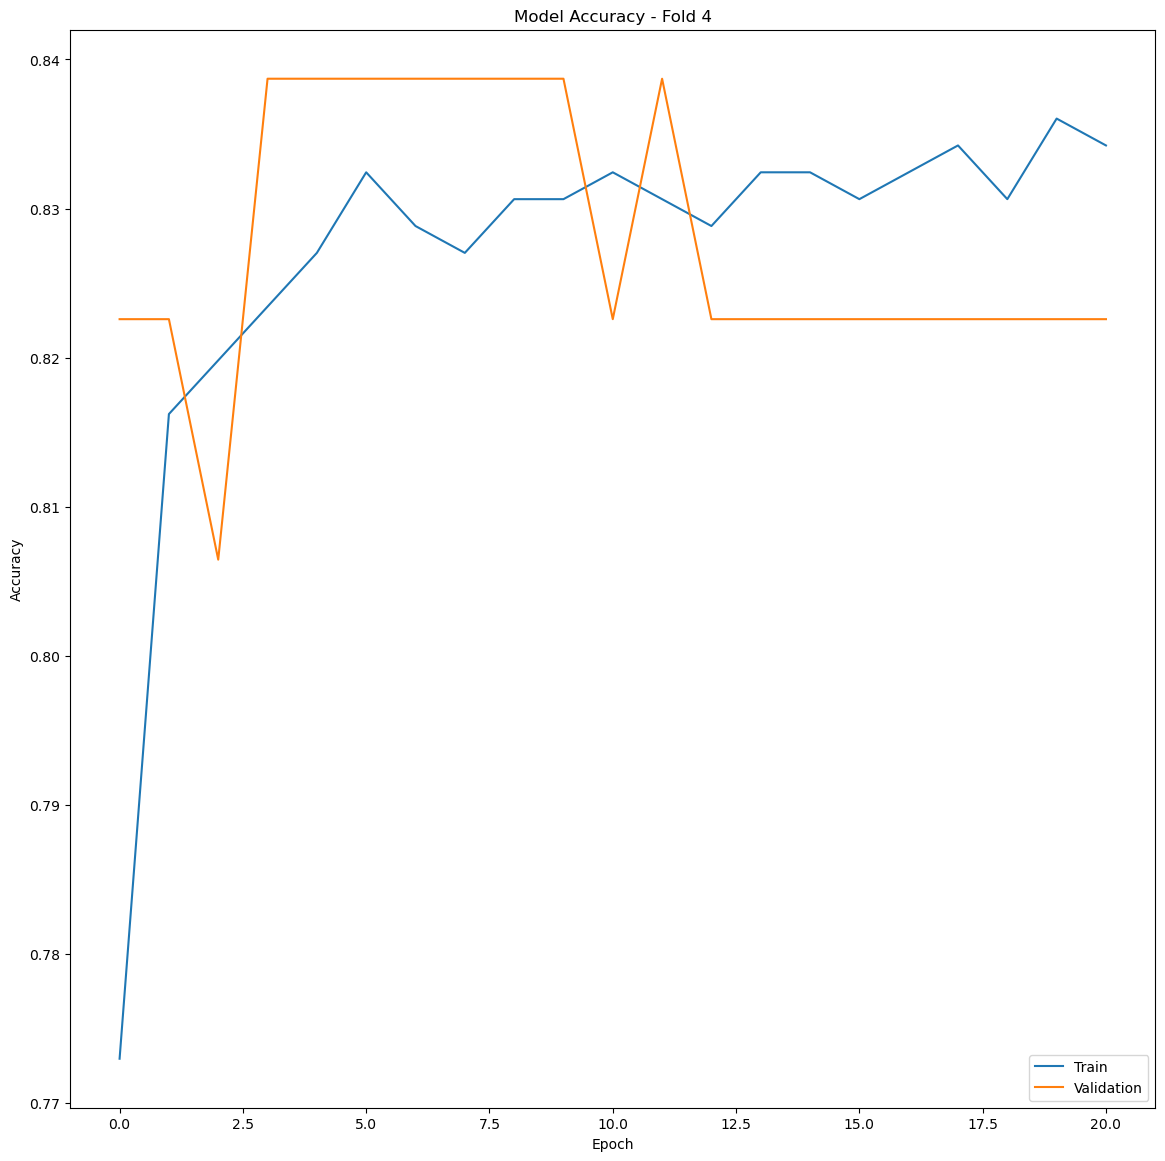

2/2 [==============================] - 0s 13ms/step - loss: 0.4790 - accuracy: 0.8226
##### Fold 5
Epoch 1/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7527 - accuracy: 0.8126 - val_loss: 0.5752 - val_accuracy: 0.8065 - lr: 6.2500e-05
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7526 - accuracy: 0.7946 - val_loss: 0.6032 - val_accuracy: 0.7742 - lr: 6.2500e-05
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7396 - accuracy: 0.7802 - val_loss: 0.6140 - val_accuracy: 0.7903 - lr: 6.2500e-05
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7523 - accuracy: 0.7712 - val_loss: 0.6292 - val_accuracy: 0.8065 - lr: 6.2500e-05
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.7676 - val_loss: 0.6476 - val_accuracy: 0.8065 - lr: 6.2500e-05
Epoch 6/50
10/18 [===============>..............] - ETA: 0s - loss: 0.6757 - accuracy: 0.8031
Epoch 6: ReduceLROnPla

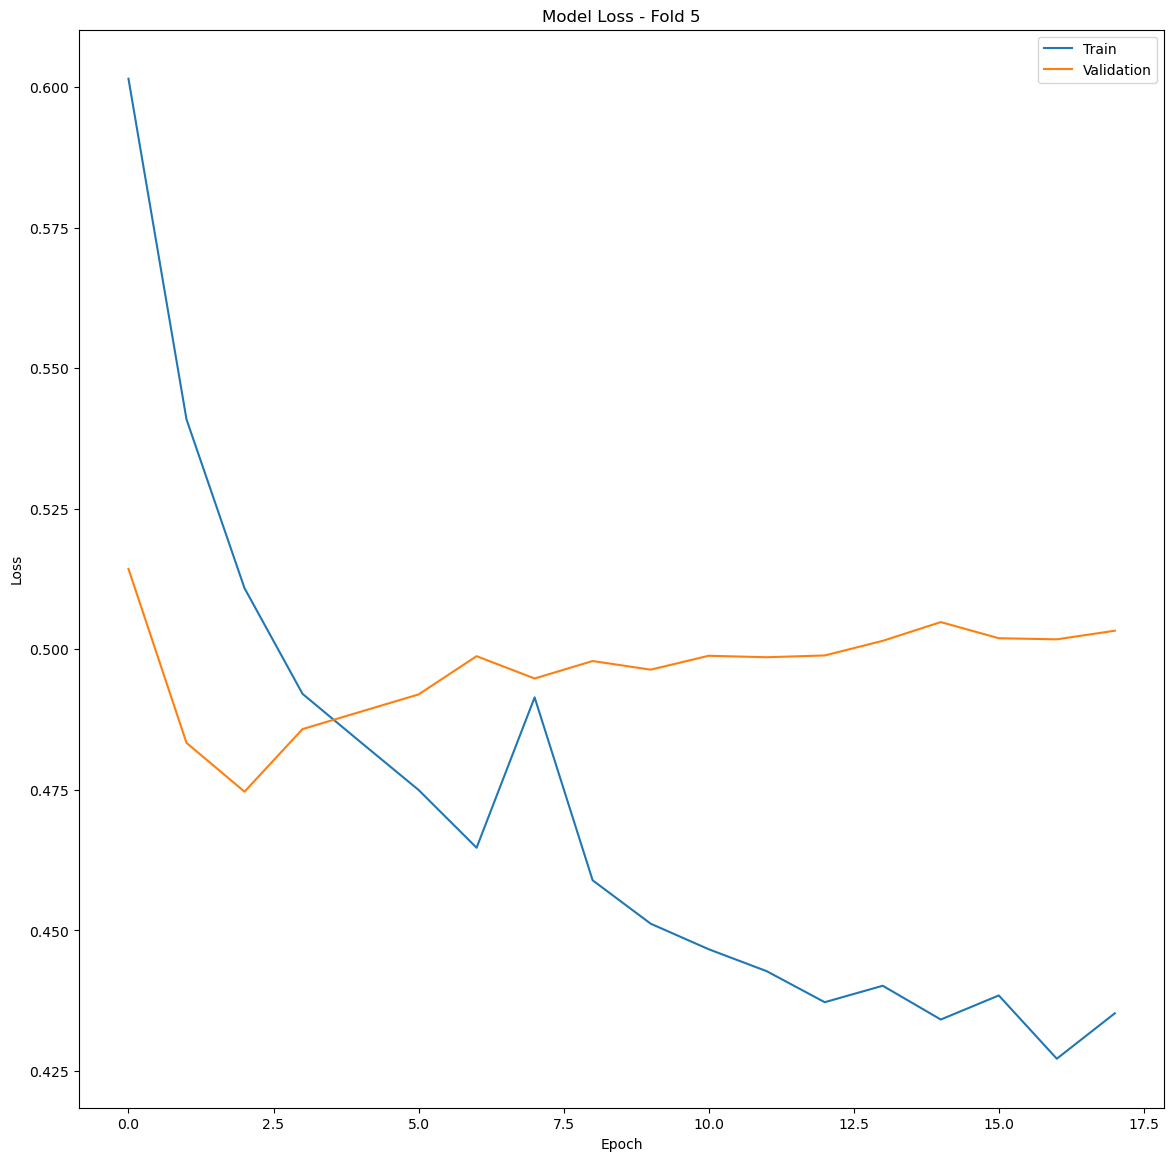

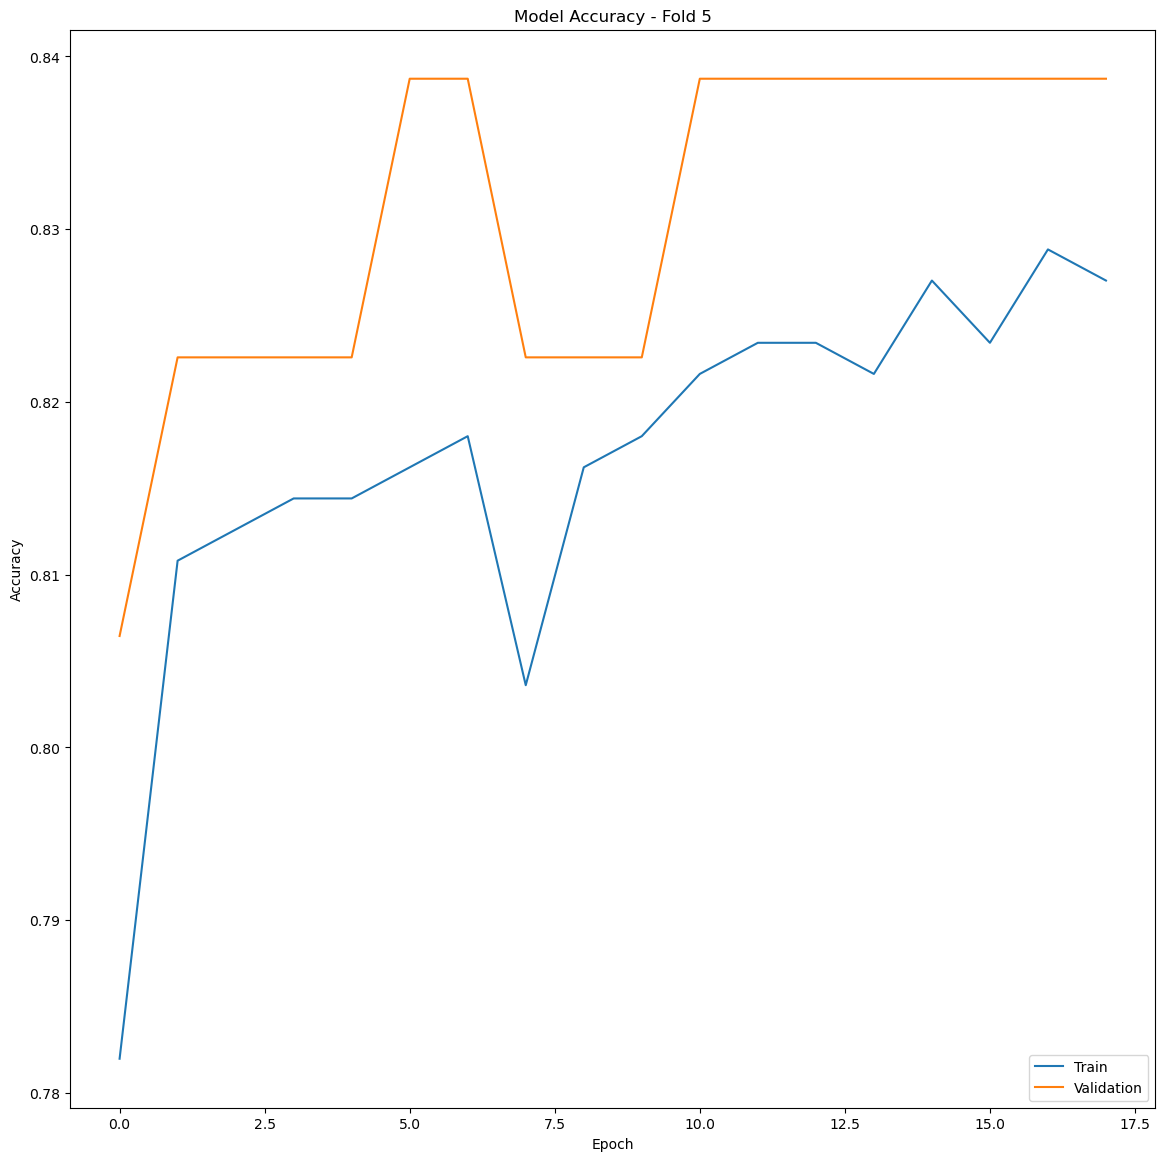

2/2 [==============================] - 0s 16ms/step - loss: 0.4392 - accuracy: 0.8226
##### Fold 6
Epoch 1/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7568 - accuracy: 0.7405 - val_loss: 0.7550 - val_accuracy: 0.6935 - lr: 3.1250e-05
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7909 - accuracy: 0.7459 - val_loss: 0.7296 - val_accuracy: 0.7097 - lr: 3.1250e-05
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7397 - accuracy: 0.7730 - val_loss: 0.7074 - val_accuracy: 0.7258 - lr: 3.1250e-05
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7282 - accuracy: 0.7910 - val_loss: 0.6910 - val_accuracy: 0.7581 - lr: 3.1250e-05
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7241 - accuracy: 0.7946 - val_loss: 0.6780 - val_accuracy: 0.7581 - lr: 3.1250e-05
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.7056 - accuracy: 0.7838 - val_loss: 0.669

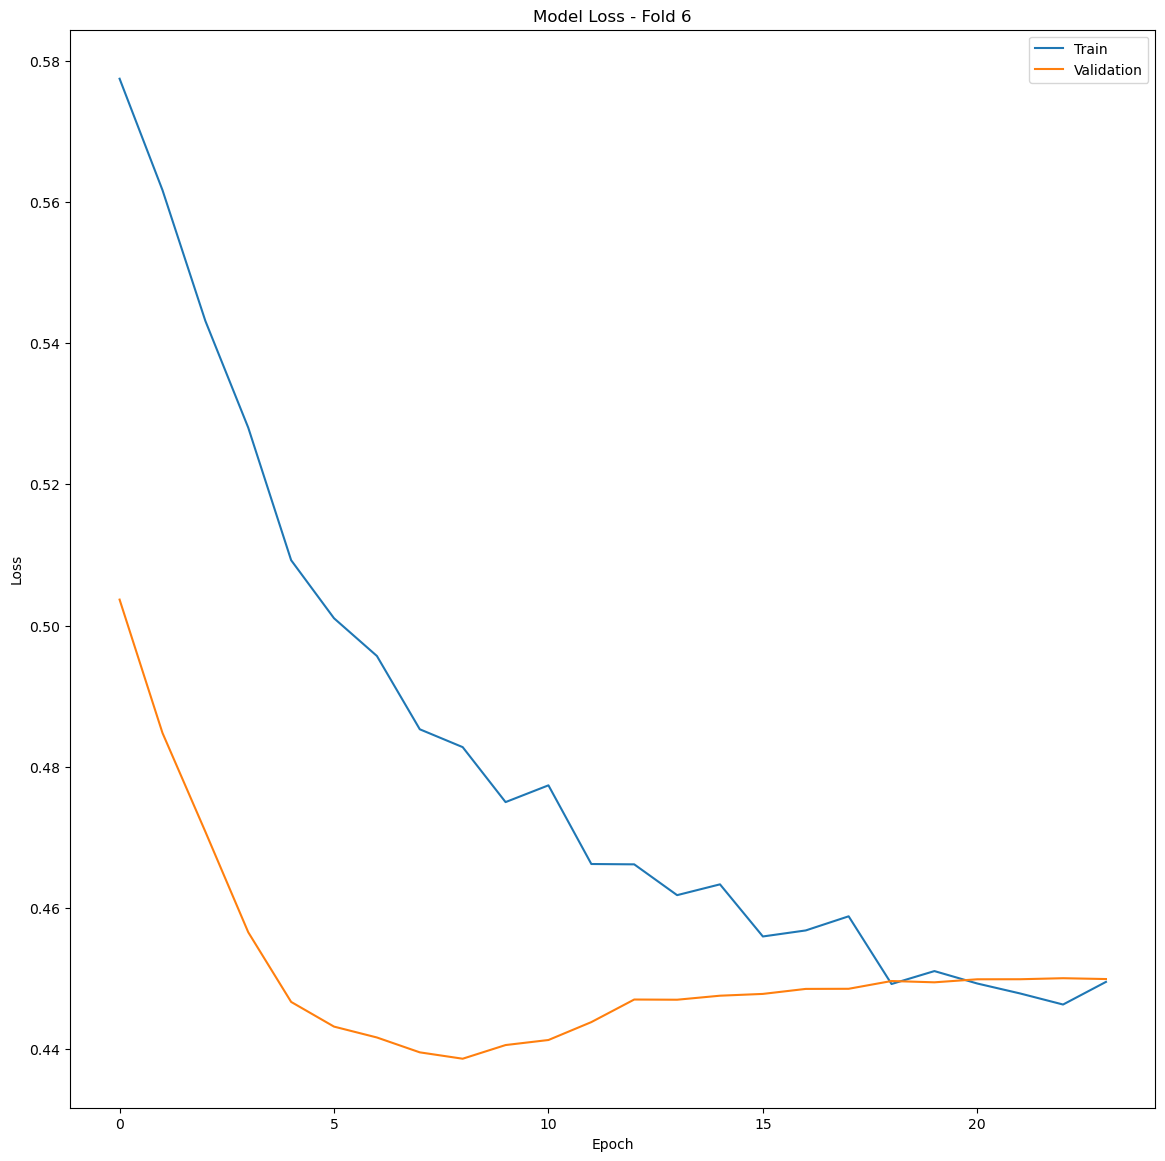

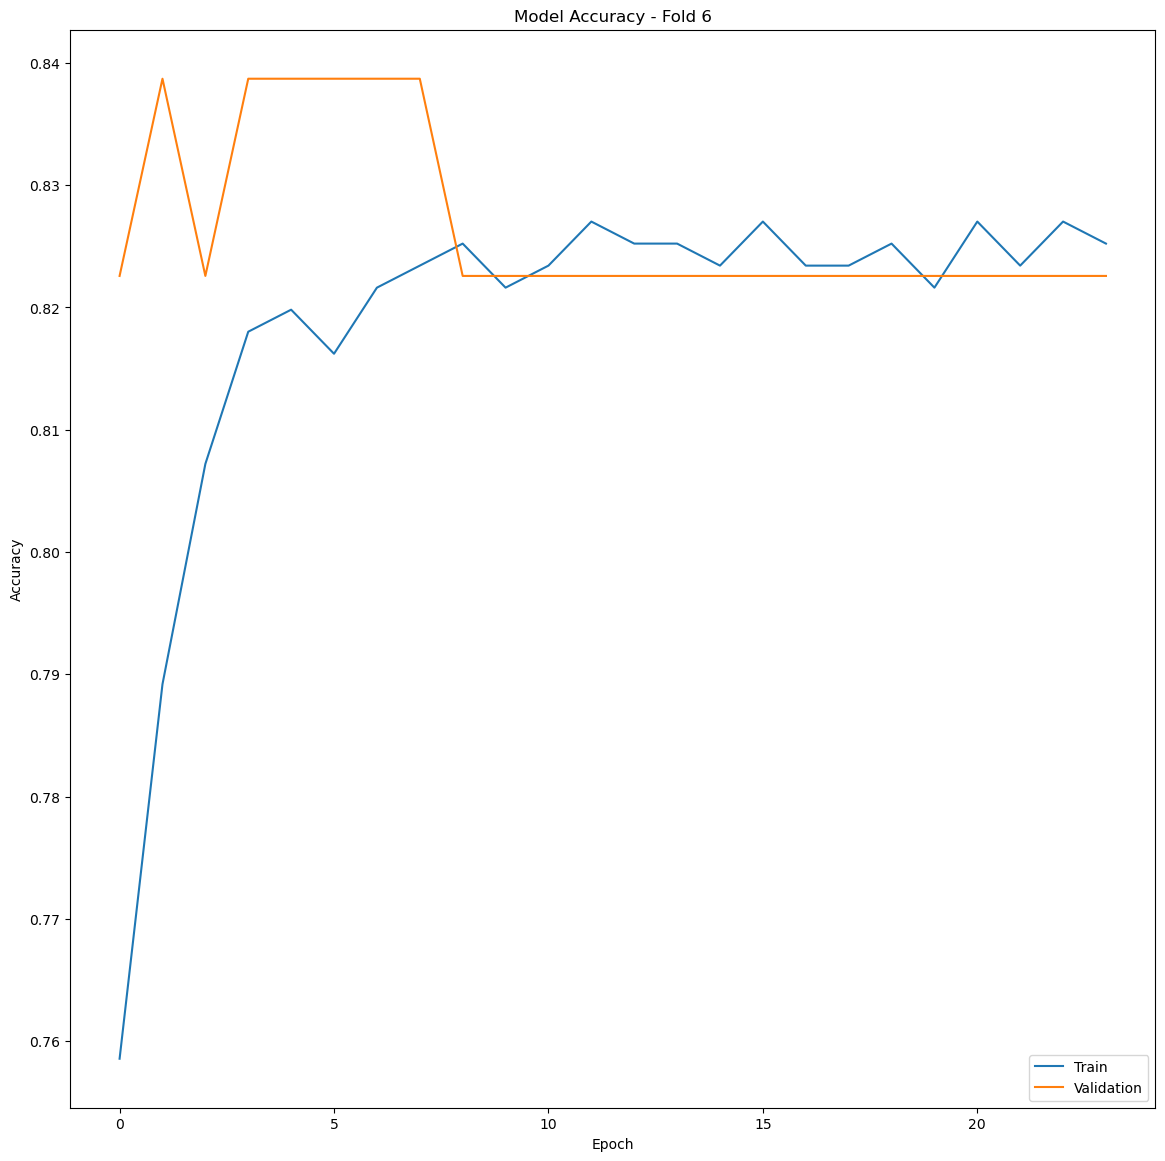

2/2 [==============================] - 0s 16ms/step - loss: 0.5123 - accuracy: 0.8065
##### Fold 7
Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7072 - accuracy: 0.8090 - val_loss: 0.5954 - val_accuracy: 0.8871 - lr: 1.5625e-05
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.7946 - val_loss: 0.5931 - val_accuracy: 0.8871 - lr: 1.5625e-05
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7316 - accuracy: 0.7946 - val_loss: 0.5902 - val_accuracy: 0.8871 - lr: 1.5625e-05
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7107 - accuracy: 0.8072 - val_loss: 0.5894 - val_accuracy: 0.8710 - lr: 1.5625e-05
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7084 - accuracy: 0.8144 - val_loss: 0.5853 - val_accuracy: 0.8710 - lr: 1.5625e-05
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7091 - accuracy: 0.8072 - val_loss: 0.5832

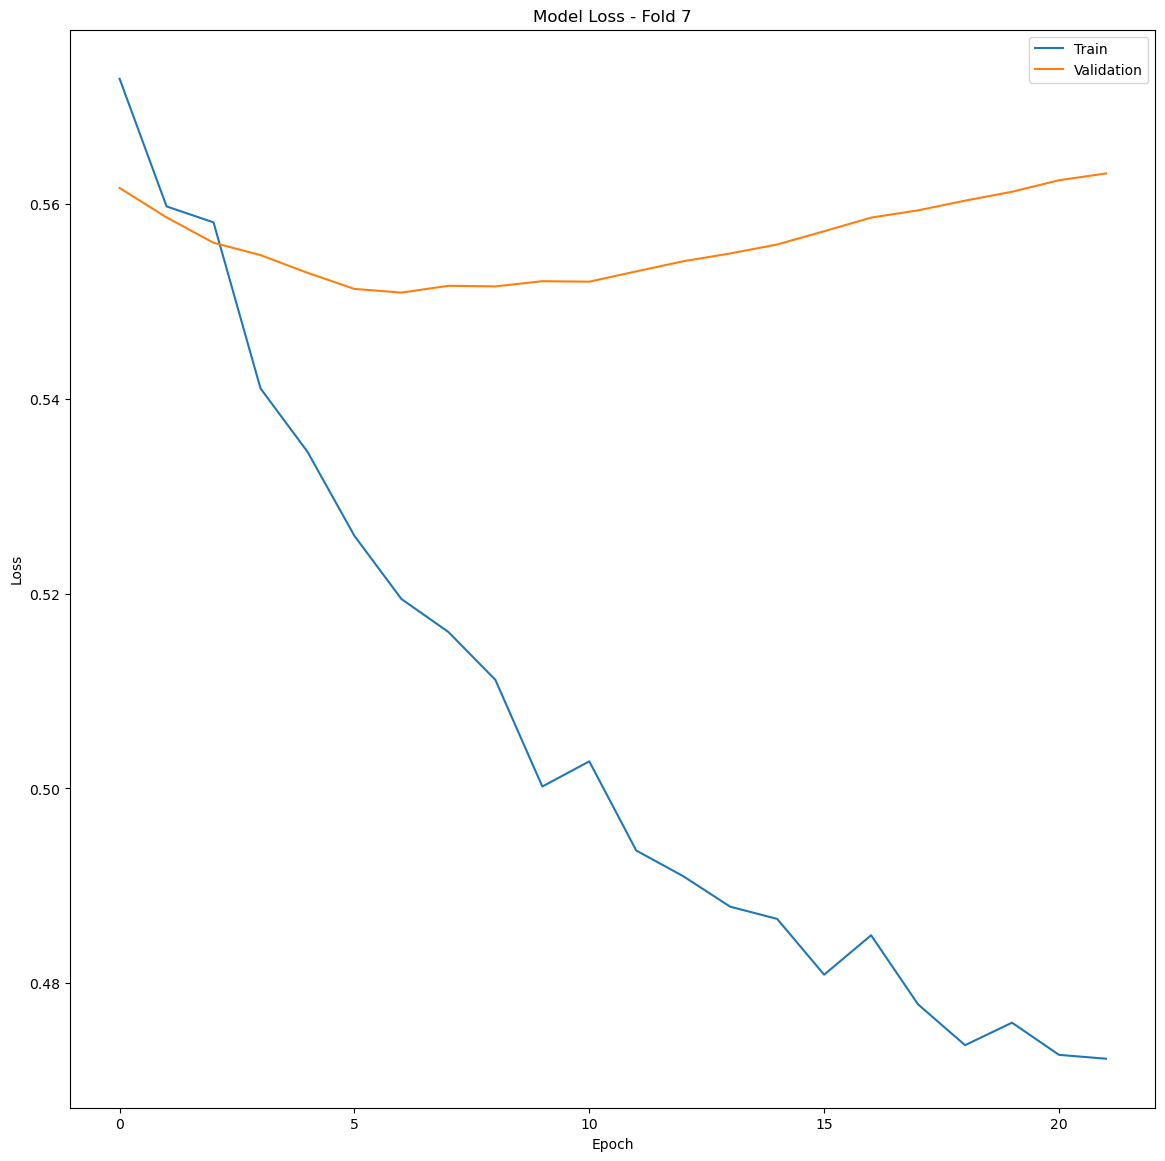

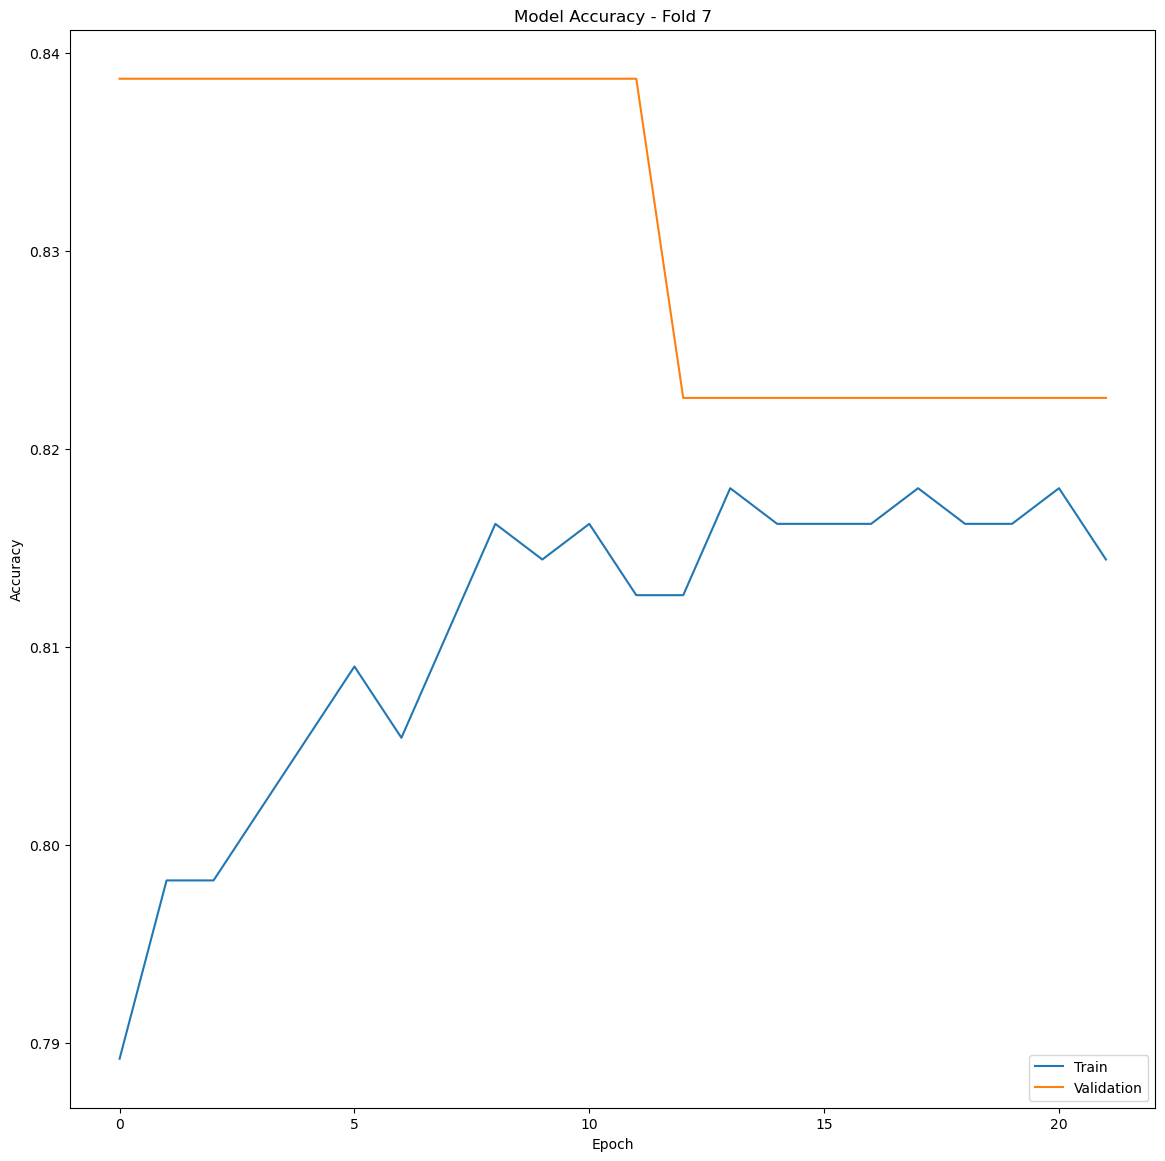

2/2 [==============================] - 0s 14ms/step - loss: 0.4776 - accuracy: 0.8226
##### Fold 8
Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6566 - accuracy: 0.8004 - val_loss: 1.2787 - val_accuracy: 0.8361 - lr: 7.8125e-06
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6603 - accuracy: 0.7986 - val_loss: 1.2780 - val_accuracy: 0.8361 - lr: 7.8125e-06
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.8237 - val_loss: 1.2785 - val_accuracy: 0.8361 - lr: 7.8125e-06
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6421 - accuracy: 0.8219 - val_loss: 1.2771 - val_accuracy: 0.8361 - lr: 7.8125e-06
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6412 - accuracy: 0.8219 - val_loss: 1.2759 - val_accuracy: 0.8361 - lr: 7.8125e-06
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6450 - accuracy: 0.8183 - val_loss: 1.2758

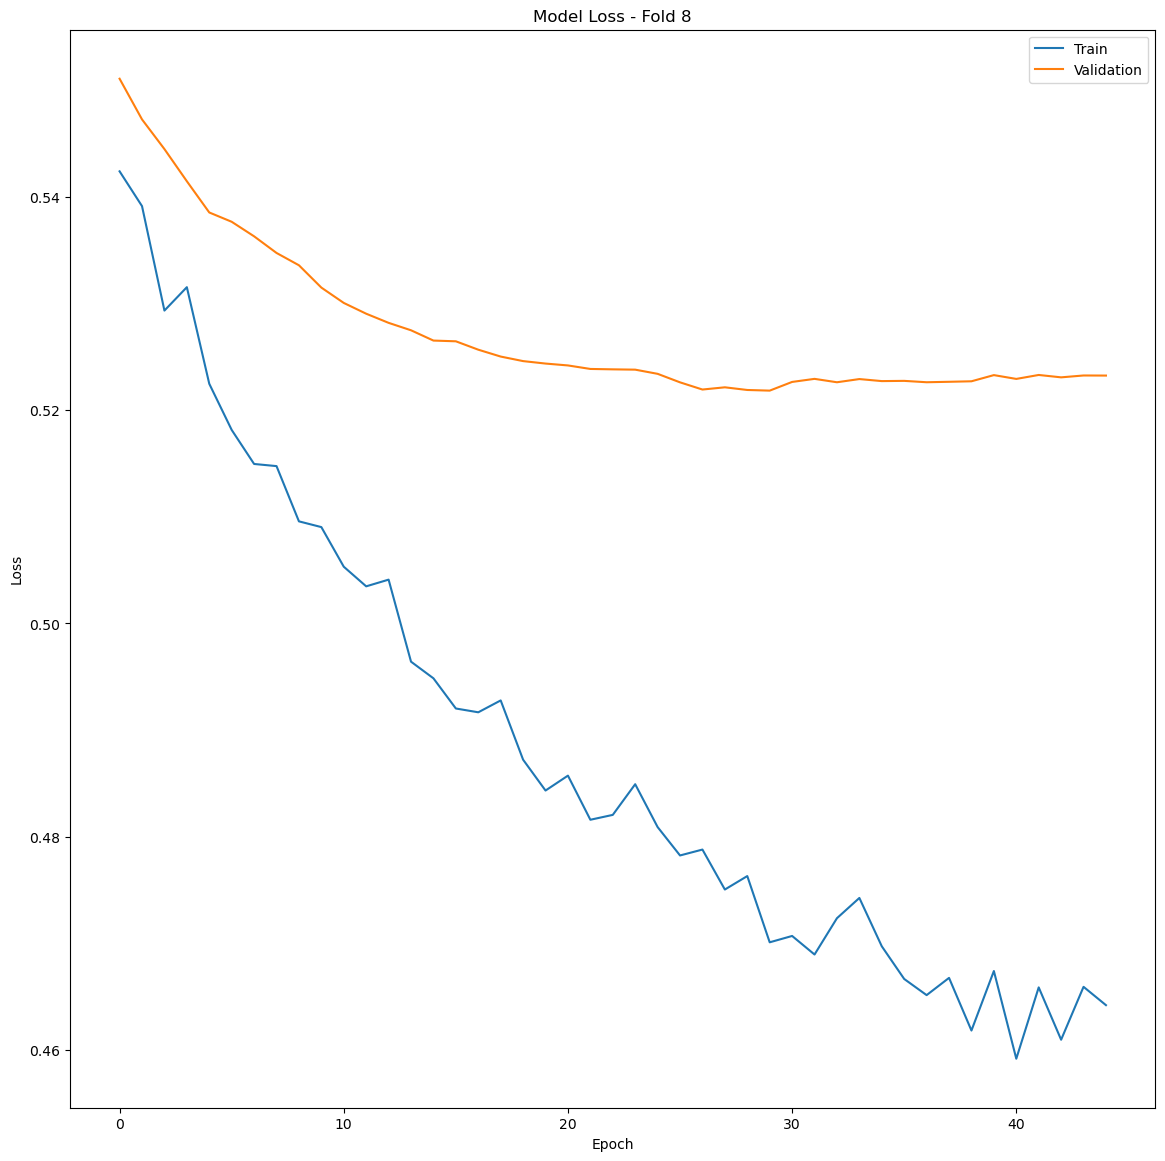

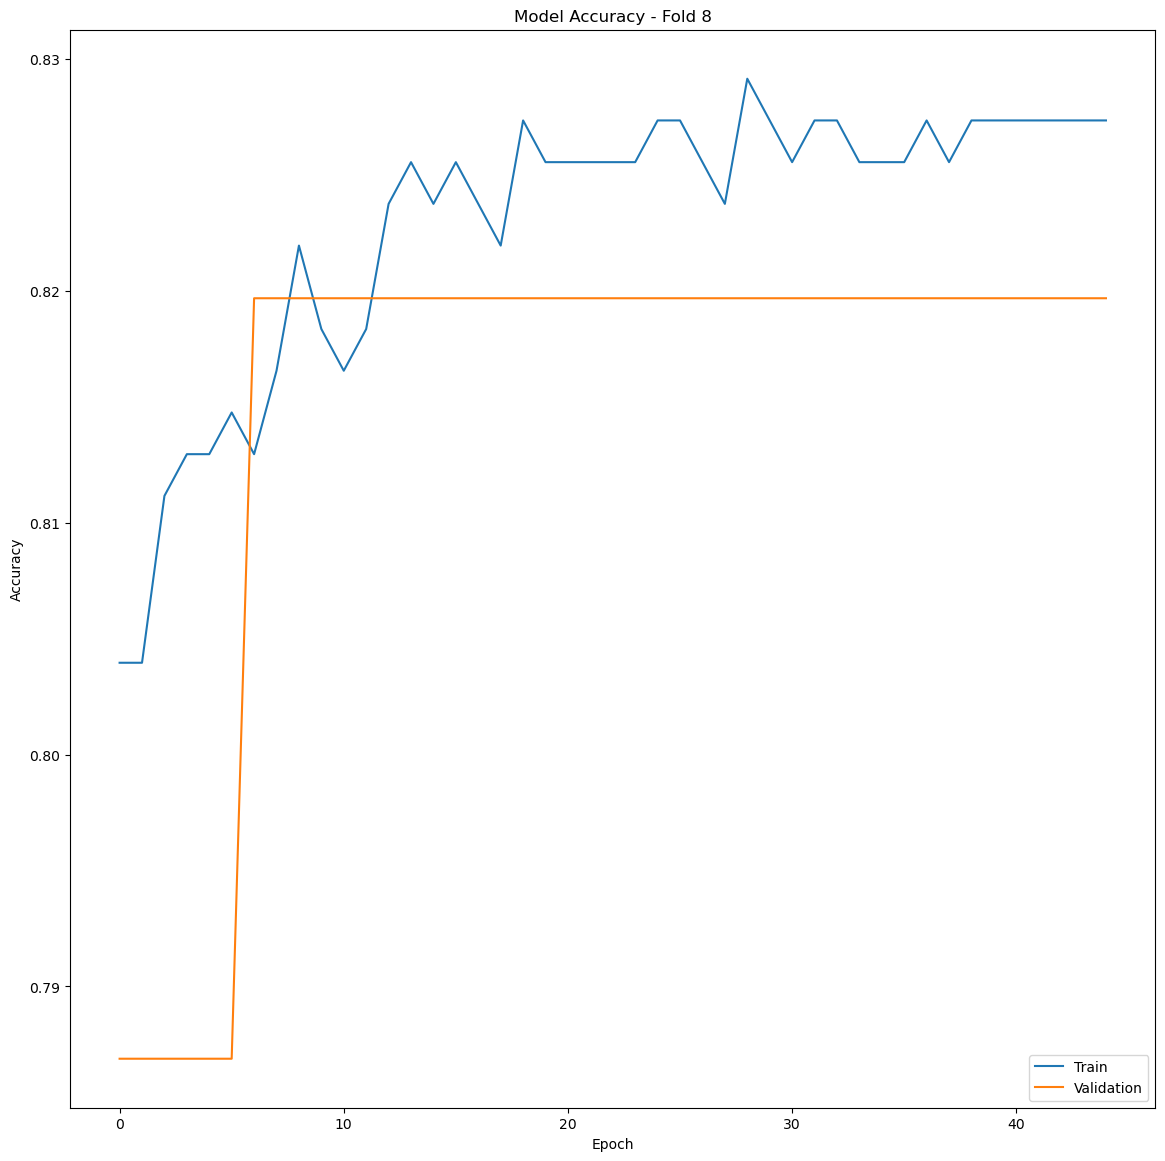

2/2 [==============================] - 0s 15ms/step - loss: 0.4912 - accuracy: 0.8197
##### Fold 9
Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.8112 - val_loss: 0.6270 - val_accuracy: 0.8525 - lr: 3.9063e-06
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.6728 - accuracy: 0.8112 - val_loss: 0.6276 - val_accuracy: 0.8525 - lr: 3.9063e-06
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7014 - accuracy: 0.8112 - val_loss: 0.6272 - val_accuracy: 0.8525 - lr: 3.9063e-06
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.7001 - accuracy: 0.8183 - val_loss: 0.6271 - val_accuracy: 0.8361 - lr: 3.9063e-06
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.6805 - accuracy: 0.7986 - val_loss: 0.6265 - val_accuracy: 0.8361 - lr: 3.9063e-06
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.8094 - val_loss: 0.6266

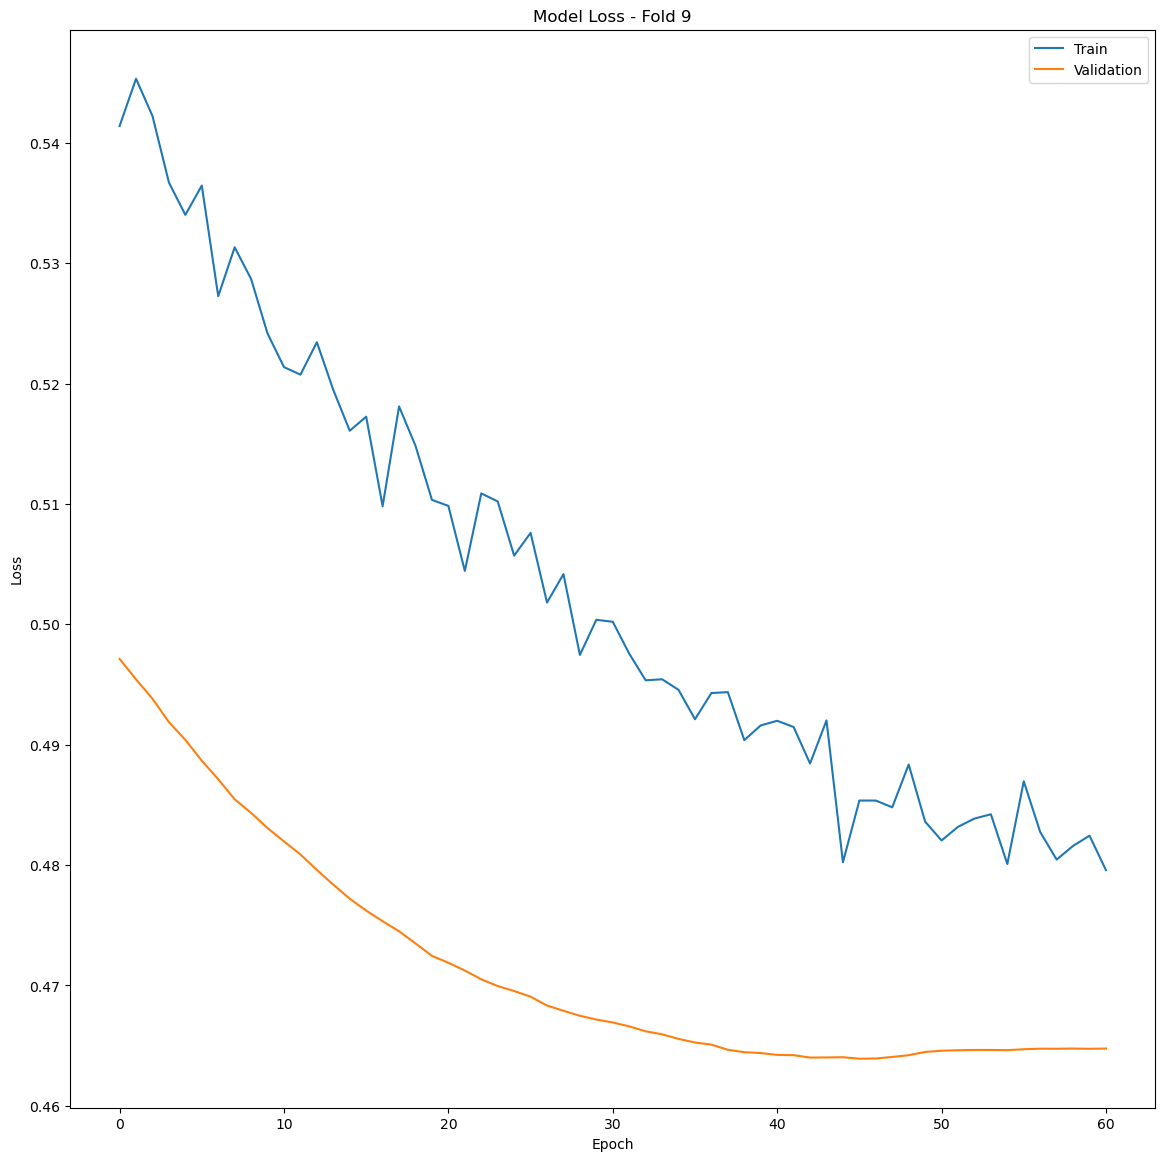

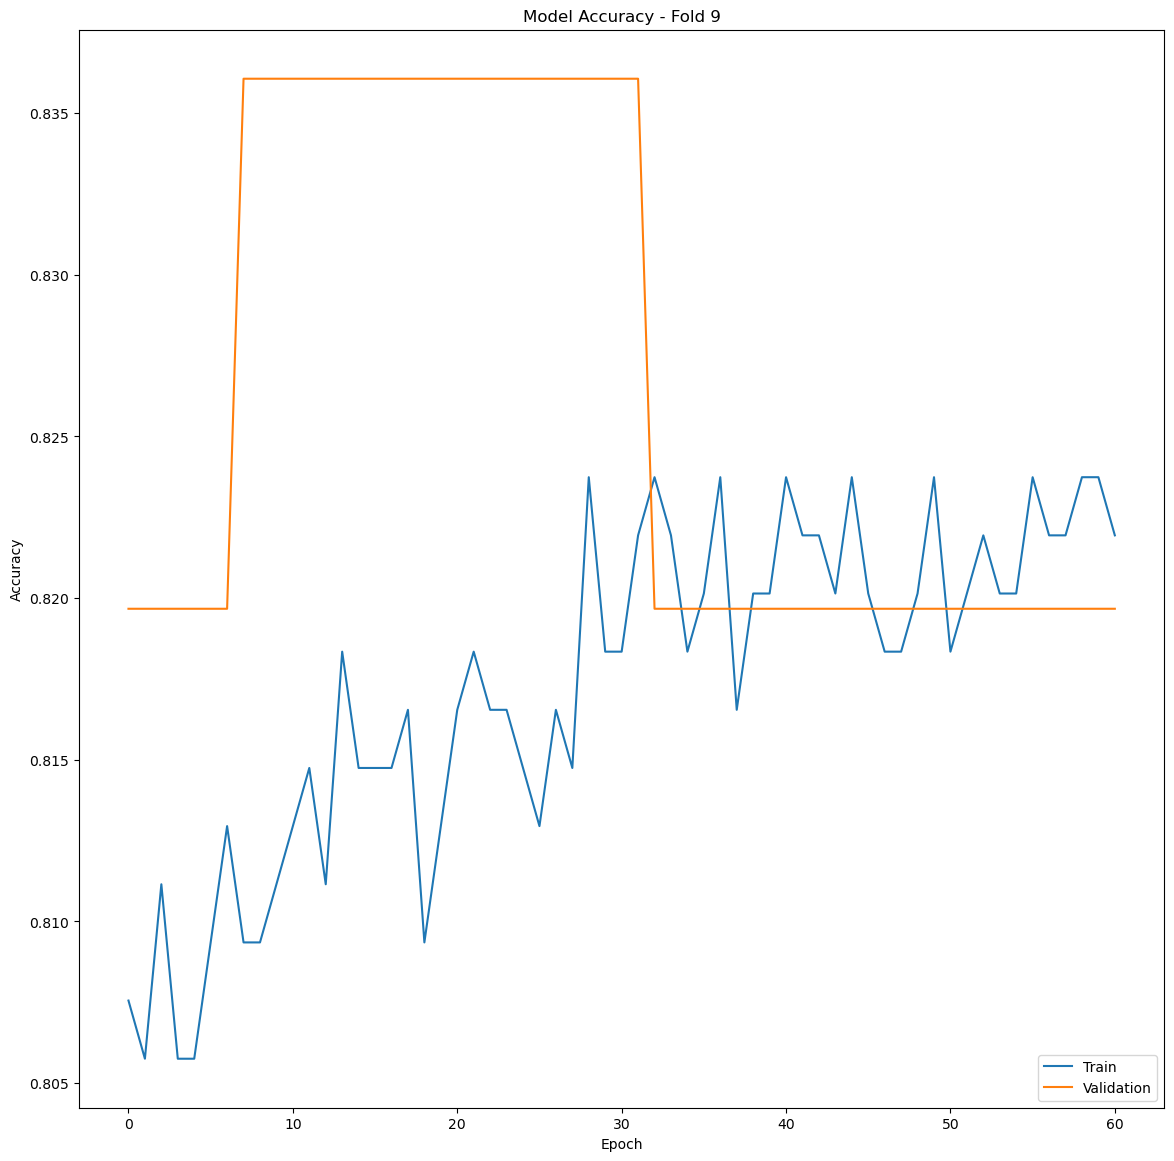

2/2 [==============================] - 0s 14ms/step - loss: 0.4758 - accuracy: 0.8361
##### Fold 10
Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.8094 - val_loss: 0.5837 - val_accuracy: 0.8525 - lr: 1.9531e-06
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.8201 - val_loss: 0.5849 - val_accuracy: 0.8525 - lr: 1.9531e-06
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.8076 - val_loss: 0.5863 - val_accuracy: 0.8525 - lr: 1.9531e-06
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6959 - accuracy: 0.8076 - val_loss: 0.5874 - val_accuracy: 0.8525 - lr: 1.9531e-06
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6901 - accuracy: 0.8094 - val_loss: 0.5888 - val_accuracy: 0.8525 - lr: 1.9531e-06
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.8201
Epoch 6: ReduceLROnPl

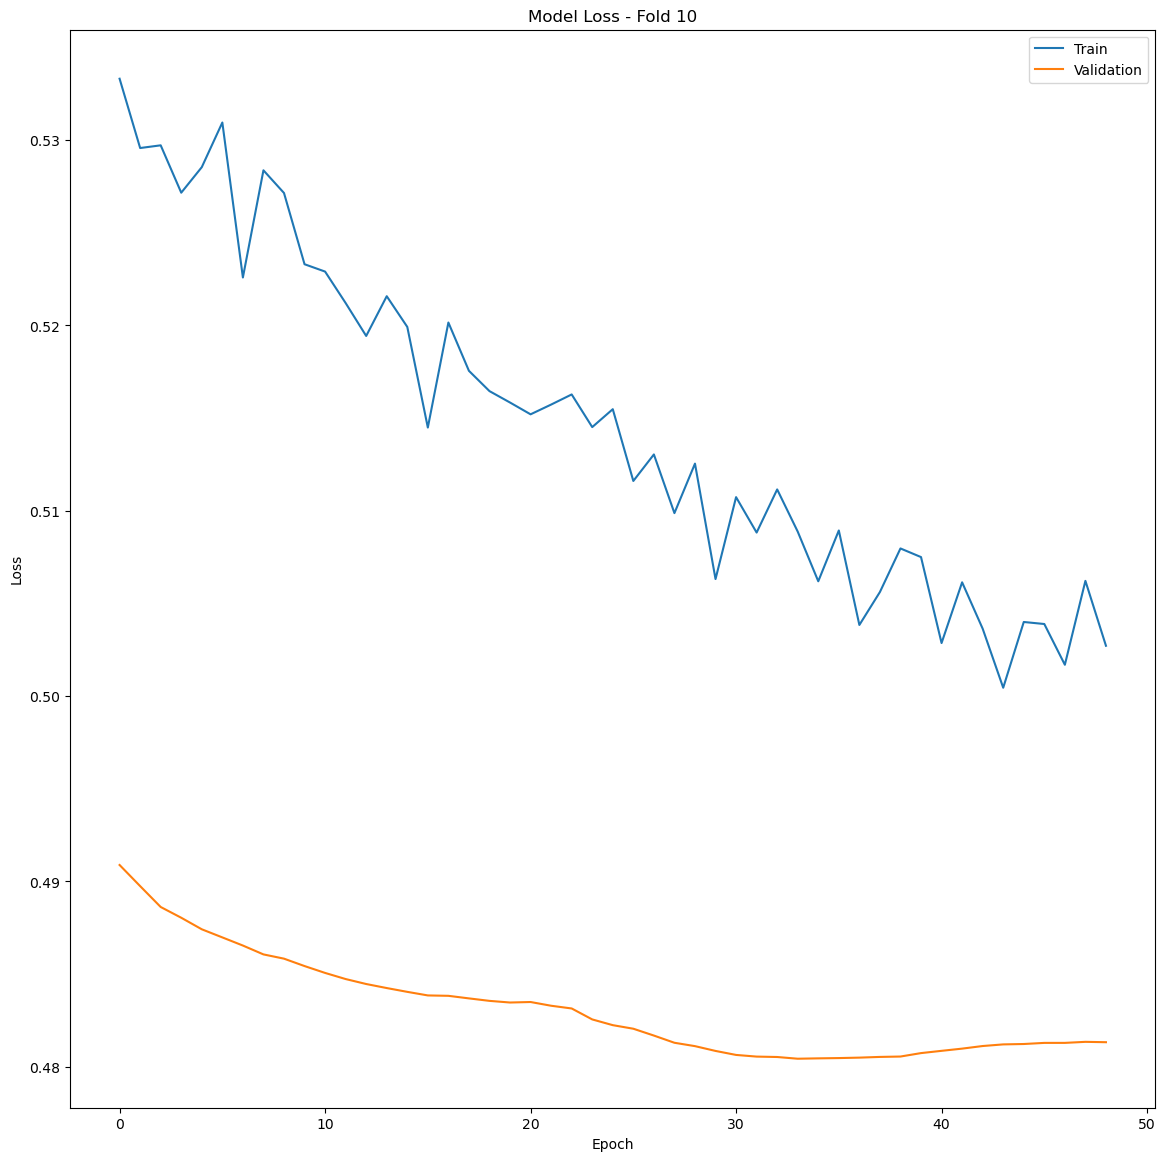

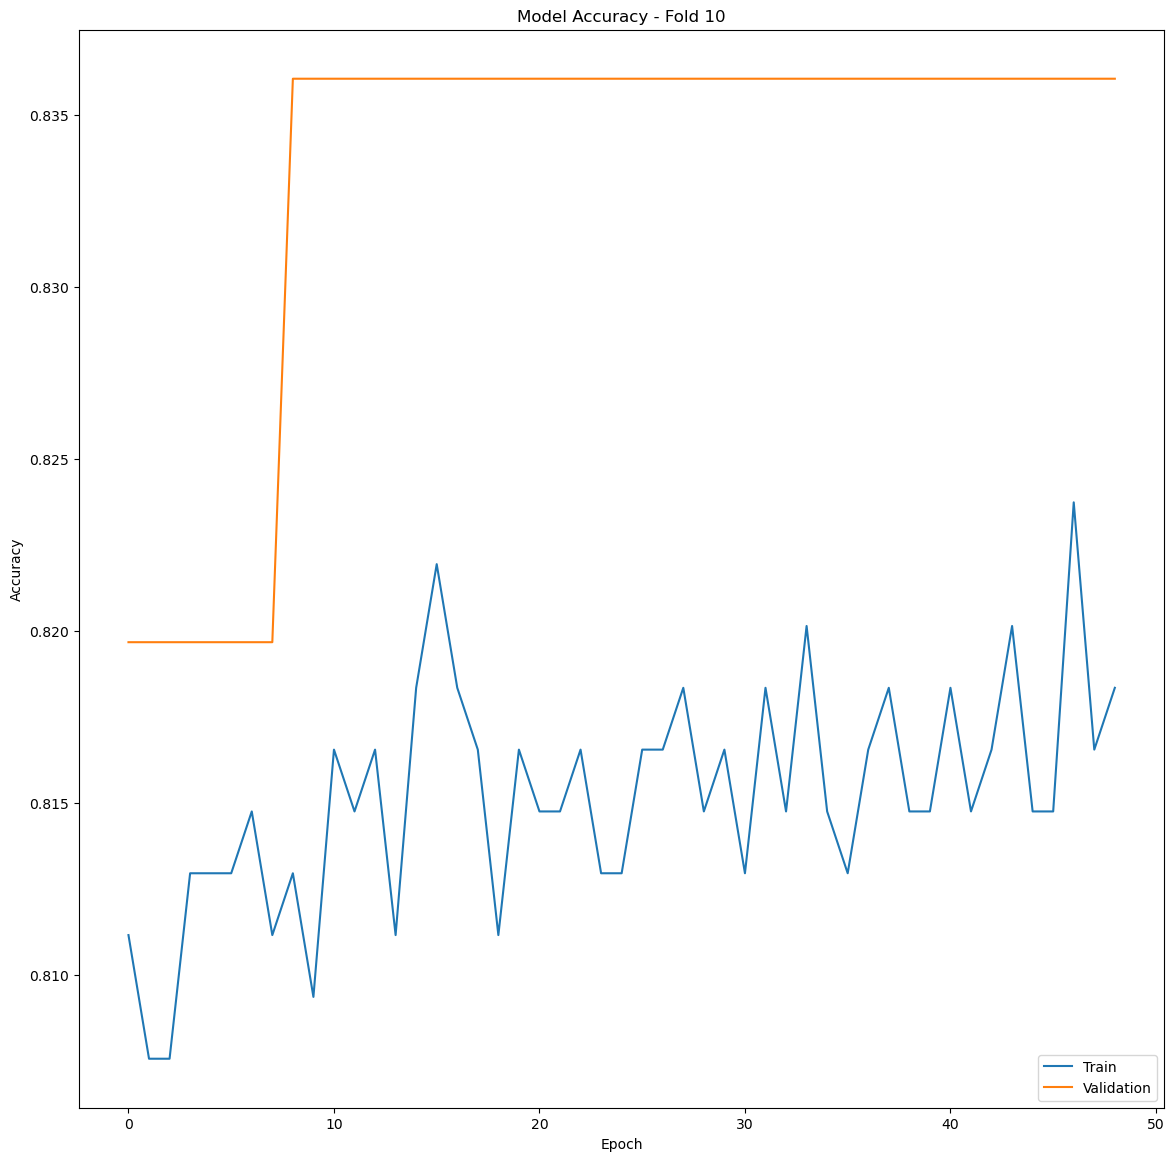

2/2 [==============================] - 0s 16ms/step - loss: 0.4644 - accuracy: 0.8361


In [21]:
BATCH_SIZE = 32

# Initialize an empty list to store the predictions of individual models:
model_predictions = []
meta_models = {}
for model in models:
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

epoch_i = 1
# Iterate through each fold of the k-fold cross-validation:
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df, y=dataset_df['Class'])):
    print('##### Fold', i+1)
    
    # Fetch values corresponding to the index
    train_df = dataset_df.iloc[train_index]
    valid_df = dataset_df.iloc[valid_index]
    valid_ids = valid_df.index.values

    # Train the individual models on train_data and make predictions on valid_data
    model_predictions_fold = []
    for model, feat_list in zip(models,top_feature_lists):
        # Define the ReduceLROnPlateau and EarlyStopping callback
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
        # Prepare the train_data and valid_data using df_to_dataset
        train_data = df_to_dataset(train_df[feat_list+['Class']])
        valid_data = df_to_dataset(valid_df[feat_list+['Class']])

        model.fit(train_data, epochs=50, batch_size=BATCH_SIZE,validation_data=valid_data, class_weight=class_weight, 
              use_multiprocessing=True, callbacks=[reduce_lr, early_stopping ])
        predictions = model.predict(train_data)
        model_predictions_fold.append(predictions)

    # Store the predictions of individual models for this fold
    model_predictions.append(model_predictions_fold)
    # Define the ReduceLROnPlateau and EarlyStopping callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    datasets = [tfds.as_numpy(df_to_dataset(train_df[feat_list]).rebatch(len(train_df))) for feat_list in top_feature_lists]
    valid_datasets = [tfds.as_numpy(df_to_dataset(valid_df[feat_list]).rebatch(len(valid_df))) for feat_list in top_feature_lists]
    meta_model.fit([y for x in datasets for y in x],
               tf.convert_to_tensor(train_df['Class'].values), 
               epochs=200, 
               validation_data=([y for x in valid_datasets for y in x],valid_df['Class'].values),
                    batch_size=BATCH_SIZE, use_multiprocessing=True, callbacks=[reduce_lr, early_stopping ])
    

    # Store the model
    meta_models[f"fold_{i+1}"] = meta_model
    #epoch_i += len(meta_model.history.history['loss']) - 1

    # Plot loss
    plt.figure(figsize=(14,14))
    plt.plot(meta_model.history.history['loss'])
    plt.plot(meta_model.history.history['val_loss'])
    plt.title(f'Model Loss - Fold {i+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot test accuracy
    plt.figure(figsize=(14,14))
    plt.plot(meta_model.history.history['accuracy'])
    plt.plot(meta_model.history.history['val_accuracy'])
    plt.title(f'Model Accuracy - Fold {i+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

    # Predict on the validation data
    predictions = meta_model.predict([y for x in valid_datasets for y in x])

    # Store the predictions in the oof dataframe
    oof.loc[valid_ids, 0] = predictions.flatten()   

    # Evaluate and store the metrics in respective dicts
    evaluation = meta_model.evaluate([y for x in valid_datasets for y in x],valid_df['Class'].values,return_dict=True, use_multiprocessing=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    margin_loss_dict[f"fold_{i+1}"]= evaluation["loss"]

In [22]:
datasets

In [23]:
# BATCH_SIZE = 8
# # Define the Capsule Network model
# #model = CapsuleNetwork()

# # Compile the model
# #model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# # Define the ReduceLROnPlateau and EarlyStopping callback
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# epoch_i = 1
# # Loop through each fold
# for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df,y=dataset_df['Class'])):
#     print('##### Fold',i+1)

#     # Fetch values corresponding to the index 
#     train_df = dataset_df.iloc[train_index]
#     valid_df = dataset_df.iloc[valid_index]
#     valid_ids = valid_df.index.values

#     train_data = df_to_dataset(train_df)
#     valid_data = df_to_dataset(valid_df)

#     # Train the model
#     #model.fit(train_data, train_target, epochs=20, batch_size=BATCH_SIZE, validation_data=(valid_data,valid_target), class_weight=class_weight, use_multiprocessing=True, callbacks=[reduce_lr, early_stopping ])
#     model.fit(train_data, epochs=1000, batch_size=BATCH_SIZE, validation_data=valid_data, class_weight=class_weight, 
#               use_multiprocessing=True, callbacks=[reduce_lr, early_stopping ], initial_epoch=epoch_i)
#     # Store the model
#     models[f"fold_{i+1}"] = model
#     epoch_i += len(model.history.history['loss']) - 1

#     # Plot loss
#     plt.figure(figsize=(14,14))
#     plt.plot(model.history.history['loss'])
#     plt.plot(model.history.history['val_loss'])
#     plt.title(f'Model Loss - Fold {i+1}')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper right')
#     plt.show()

#     # Plot test accuracy
#     plt.figure(figsize=(14,14))
#     plt.plot(model.history.history['accuracy'])
#     plt.plot(model.history.history['val_accuracy'])
#     plt.title(f'Model Accuracy - Fold {i+1}')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='lower right')
#     plt.show()

#     # Predict on the validation data
#     predictions = model.predict(valid_data)

#     # Store the predictions in the oof dataframe
#     oof.loc[valid_ids, 0] = predictions.flatten()   

#     # Evaluate and store the metrics in respective dicts
#     evaluation = model.evaluate(valid_data,return_dict=True, use_multiprocessing=True)
#     accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
#     margin_loss_dict[f"fold_{i+1}"]= evaluation["loss"]

The capsule network architecture exhibits remarkable performance in terms of loss functions and accuracy, both during training and validation. The effectiveness of this network can be attributed to its ingenious design, incorporating principles that enable it to excel in handling complex data.

One key feature of the capsule network is its hierarchical representation. Unlike traditional convolutional neural networks (CNNs) that rely heavily on pooling layers, which may inadvertently discard vital spatial information, capsule networks leverage capsules - groups of neurons representing specific entities or parts. By encoding the presence and properties of these entities, capsules provide a more nuanced and structured representation of the data.

A crucial component of the capsule network is the dynamic routing algorithm, which facilitates effective communication between capsules. Through dynamic routing, information is accurately routed and aggregated, ensuring that the outputs of capsules are updated based on consensus between lower-level and higher-level capsules. This dynamic routing mechanism refines the network's representation, resulting in improved overall performance.

The capsule network's distinct feature is the separation of pose and activation vectors. Unlike conventional networks that primarily rely on activation values, capsule networks additionally utilize pose vectors, encoding properties and transformation parameters of the entities. By optimizing both activation and pose vectors, the network can more effectively capture intricate patterns and discern between different classes.

Moreover, the inclusion of a reconstruction loss in the capsule network further enhances its capabilities. The decoder network in the network's architecture reconstructs the input vector from the pose vector of the predicted class. This reconstruction loss function encourages the network to learn meaningful representations while effectively regularizing its performance. By reconstructing the input, the network can capture essential features while reducing the influence of noise or extraneous variations in the data.

These elements, in combination, contribute to the impressive performance exhibited by the capsule network on your data. The hierarchical representation, dynamic routing, and the separation of pose and activation vectors enable the network to adeptly capture complex patterns and relationships. Furthermore, the incorporation of the reconstruction loss encourages the network to learn meaningful representations, leading to improved discrimination capabilities. In essence, the capsule network's unique architecture and design choices make it exceptionally well-suited for handling complex data, resulting in exemplary performance metrics such as low loss and high accuracy during both training and validation stages.

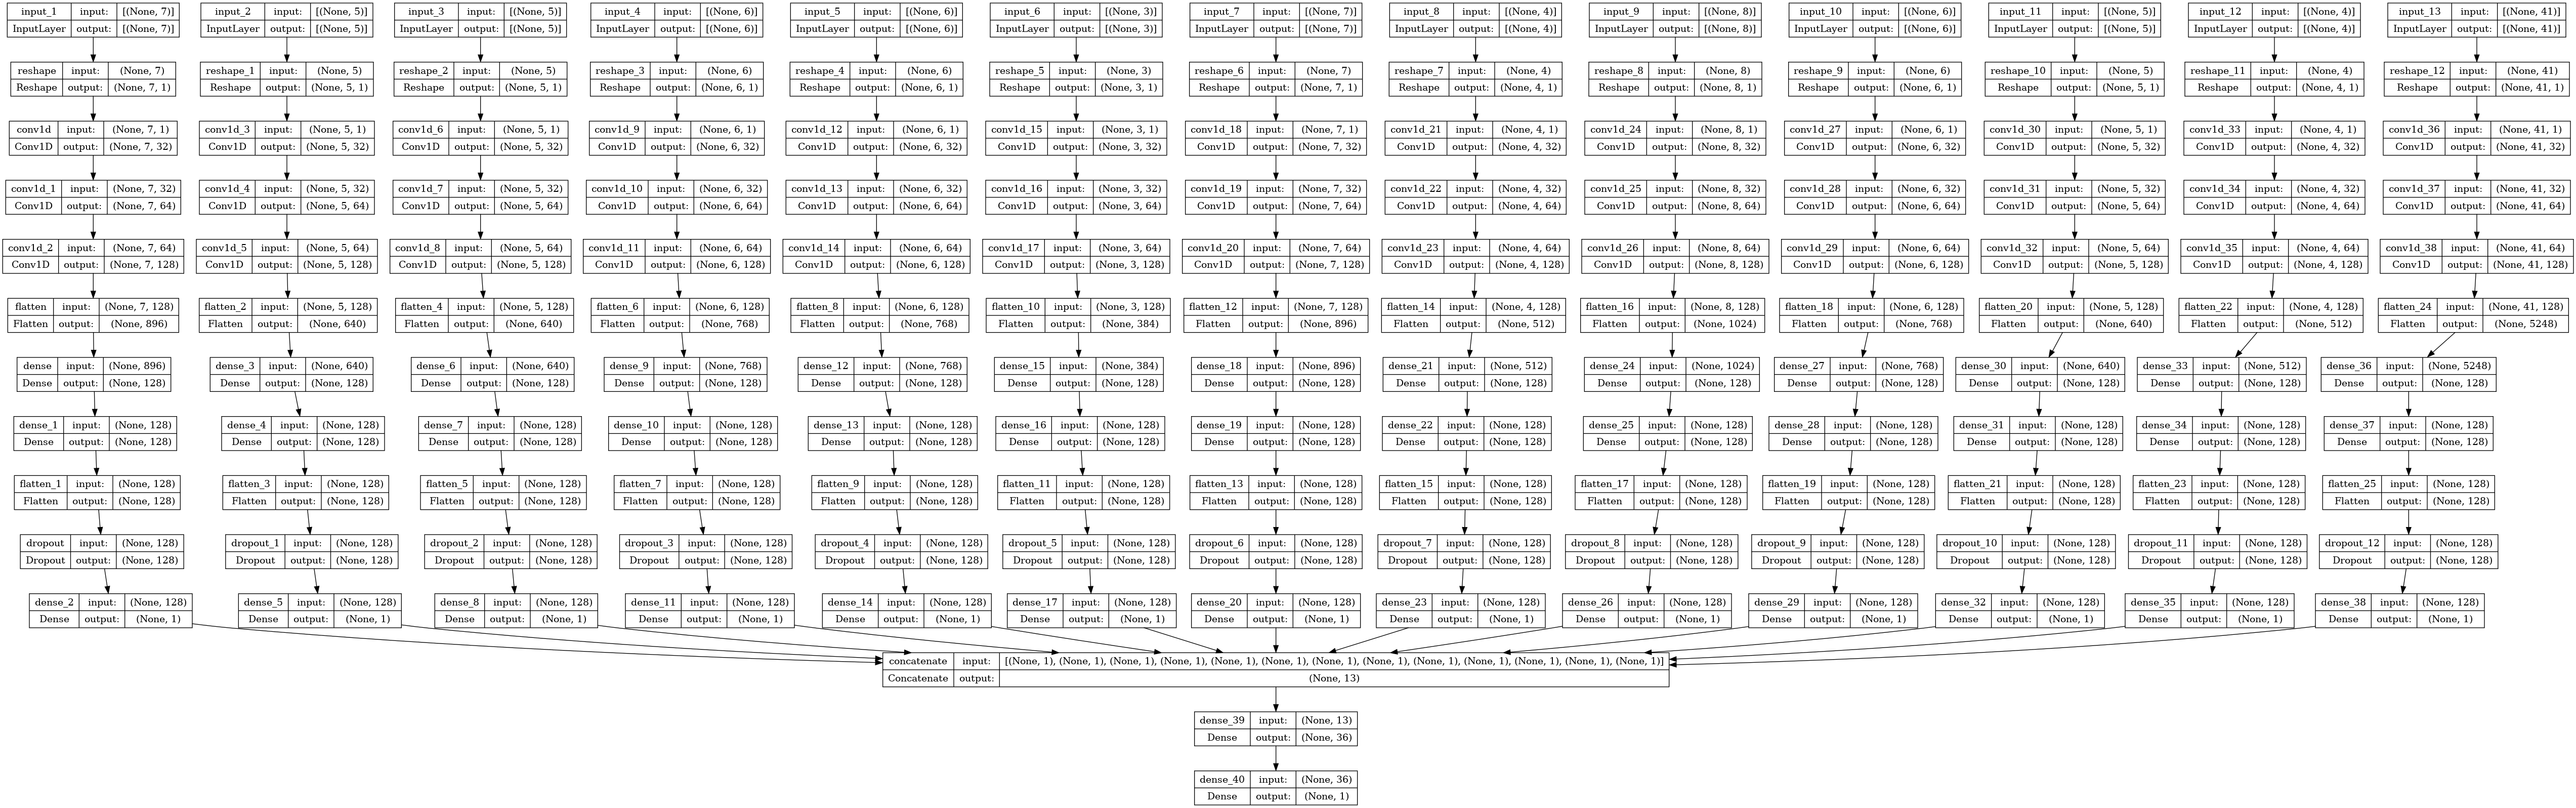

In [24]:
from PIL import Image
import IPython.display as display
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(meta_models['fold_1'], to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture diagram
display.Image("model.png")

Now, let us check the evaluation metrics for each fold and its average value.

In [25]:
average_loss = 0
average_acc = 0
best_model = None
best_accuracy = 0.0
best_loss = float('inf')

for _model in meta_models:
    average_loss += margin_loss_dict[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {margin_loss_dict[_model]:.4f}")
    # Update the best model if the current model has higher accuracy and lower loss
    if accuracy[_model] >= best_accuracy or (accuracy[_model] == best_accuracy and margin_loss_dict[_model] <= best_loss):
        best_accuracy = accuracy[_model]
        best_loss = margin_loss_dict[_model]
        best_model = meta_models[_model]


print(f"\nAverage accuracy: {average_acc/10:.4f}  Average loss: {average_loss/10:.4f}")

fold_1: acc: 0.7903 loss: 0.5560
fold_2: acc: 0.8226 loss: 0.6081
fold_3: acc: 0.8226 loss: 0.5277
fold_4: acc: 0.8226 loss: 0.4790
fold_5: acc: 0.8226 loss: 0.4392
fold_6: acc: 0.8065 loss: 0.5123
fold_7: acc: 0.8226 loss: 0.4776
fold_8: acc: 0.8197 loss: 0.4912
fold_9: acc: 0.8361 loss: 0.4758
fold_10: acc: 0.8361 loss: 0.4644

Average accuracy: 0.8201  Average loss: 0.5031


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Neural Networks. Let us pick one model from models dict and inspect it.

## Permutation Importance

This approach evaluates the impact of shuffling the values of each feature on the model's performance. By measuring the drop in performance after permuting a feature, you can estimate its importance.

from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin
valid_datasets = [tfds.as_numpy(df_to_dataset(valid_df[feat_list]).rebatch(len(valid_df))) for feat_list in top_feature_lists]
class ModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self.model.fit(X,y)

    def predict(self, X):
        return self.model.predict(X)

# Create a model wrapper instance
model_wrapper = ModelWrapper(best_model)

# Define a scoring function based on model predictions
def scoring_function(model_wrapper, X, y):
    y_pred = model_wrapper.predict(X)
    # Convert continuous values to binary labels
    valid_target_binary = (y_pred > 0.5).astype(int)
    return accuracy_score(y, valid_target_binary)

# Compute permutation importances
result = permutation_importance(model_wrapper, [tf.convert_to_tensor(y) for x in valid_datasets for y in x], valid_df['Class'].values, scoring=scoring_function, n_repeats=10, random_state=42)

# Get feature importances from the result
importances = result.importances_mean

# Visualize the feature importances
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

m = [tf.convert_to_tensor(y) for x in valid_datasets for y in x]
m

In this code, model represents our trained TensorFlow neural network model. The permutation_importance() function from scikit-learn is used to compute the permutation importances. The scoring_function() is a custom scoring function that computes the performance metric (e.g., accuracy) based on the model predictions. Finally, a bar plot is created to visualize the feature importances.

Note that the above approaches are general techniques and may require modifications based on the specifics of your model and problem. Additionally, there are other techniques available for computing variable importances, such as SHAP values and LIME. The choice of method depends on the nature of the model and the insights we seek.

### Other Permutation Importance Visualizations
We have already created a bar plot to visualize the feature importances. We can enhance this plot by sorting the features in descending order of importance and adding error bars to represent the variability of the importance scores across repetitions.

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(16,16))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.errorbar(range(len(sorted_importances)), sorted_importances, yerr=result.importances_std[sorted_indices], fmt='.k')
plt.xticks(range(len(sorted_importances)), sorted_indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()


#### Feature Importance Curve

Next, wee create a cumulative feature importance curve to show the cumulative importance of features. This plot helps identify the most important features and their cumulative contribution.

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot cumulative importance curve
plt.figure(figsize=(11,11))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.show()


#### Heatmap

As we have a large number of features,we can create a heatmap to visualize the permutation importances across features. This can help identify patterns and relationships between features.

# Create a heatmap of permutation importances
import seaborn as sns

# Reshape the importances array to match the data shape
importance_matrix = importances.reshape((1, -1))

# Plot the heatmap
plt.figure(figsize=(12,12))
sns.heatmap(importance_matrix, cmap='viridis', annot=True, cbar=True)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()


# Submission

In [26]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv').set_index("Id")
print(test_df)
test_df.columns = test_df.columns.str.strip()
test_datasets = [tfds.as_numpy(df_to_dataset(test_df[feat_list]).rebatch(len(test_df))) for feat_list in top_feature_lists]
test_ds = [y for x in test_datasets for y in x]
#test_ds = df_to_dataset(test_df, shuffle=False)
predictions = best_model.predict(test_ds, batch_size=1)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

               AB   AF   AH   AM   AR   AX   AY   AZ   BC  BD   ...   FI   FL  \
Id                                                              ...             
00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

               FR   FS   GB   GE   GF   GH   GI   GL  
Id                                                    
00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 56 columns]
5/5 [===================

In [27]:
test_df
#n_predictions

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)